In [1]:
start_date=input('YYYY-MM-DD 형식을 지켜 입력해주세요 ex) 2018-01-01 : ')
end_date=input('YYYY-MM-DD 형식을 지켜 입력해주세요 ex) 2020-10-13 : ')
pred_days=int(input('How many days do you want to predict? (Prophet에만 해당) ex) 365 : '))

YYYY-MM-DD 형식을 지켜 입력해주세요 ex) 2018-01-01 : 2018-01-01
YYYY-MM-DD 형식을 지켜 입력해주세요 ex) 2020-10-13 : 2020-10-13
How many days do you want to predict? (Prophet에만 해당) ex) 365 : 20


# 1. 라이브러리

In [2]:
import pandas as pd #데이터 분석
import numpy as np #행렬 연산

import datetime # 날짜타입 사용
import random # 시드 제어

import seaborn as sns # 시각화
import matplotlib.pyplot as plt # 시각화
import scikitplot    #   conda install -c conda-forge scikit-plot  (사전에 설치)

from workalendar.asia import SouthKorea # 한국의 공휴일
import random # 시드 제어

import talib as ta # 기술적 분석 (보조지표)

from pycaret.regression import * # AutoML pycaret
#from pycaret.classification import * # AutoML pycaret
from fbprophet import Prophet # Prophet

import yfinance as yf # yahoo finance API    # pip install yfinance
import investpy # investing.com API          # pip install investpy
from pykrx import stock # krx API           # pip instasll pykrx


# 2. 입력 데이터

1) 데이터 수집기간 입력

In [3]:
# 데이터 수집기간 입력
# yahoo finance 양식, ex) yyyy-mm-dd
#start_date = '2018-01-01'
#end_date = '2020-10-13'

# investing.com 양식, ex) dd/mm/yyyy
start_date_ = start_date[8:] + '/' + start_date[5:7] + '/' + start_date[:4]
end_date_ = end_date[8:] + '/' + end_date[5:7] + '/' + end_date[:4]

# krx 양식 ex) yyyymmdd
start_date__ = start_date[0:4] + start_date[5:7] + start_date[8:10]
end_date__ = end_date[0:4] + end_date[5:7] + end_date[8:10]

# 2. 데이터 수집 (코스피지수 예측 모델)  -> Data_kospi.csv

1) 코스피 차트 데이터 및 투자지표

In [4]:
# 종합지수 (코스피) 차트 데이터
kospi_ = stock.get_index_ohlcv_by_date(start_date__, end_date__, "1001")
kospi_.columns = ['Open','High','Low','Close','Volume']

# 코스피 투자자별 공매도 거래량
kospi_short_sell_volume = stock.get_shorting_investor_volume_by_date(start_date__, end_date__, "KOSPI")
kospi_short_sell_volume.columns = ['kospi_inst_volume','kospi_indi_volume','kospi_fore_volume','kospi_etc_volume','kospi_short_sell_volume']
# 코스피 투자자별 공매도 거래대금
kospi_short_sell_value = stock.get_shorting_investor_price_by_date(start_date__, end_date__, "KOSPI")
kospi_short_sell_value.columns = ['kospi_inst_value','kospi_indi_value','kospi_fore_value','kospi_etc_value','kospi_short_sell_value']

# 참고
# 코스피 항목별 시장 거래량
#kospi_market_volume = stock.get_market_trading_volume_by_date(start_date__, end_date__, "KOSPI")
# 코스피 항목별 시장 거래대금
#kospi_market_value = stock.get_market_trading_value_by_date(start_date__, end_date__, "KOSPI")

2) 코스피 관련 주가지수

In [5]:
# 대표지수 (코스피 200)
kospi_200_ = stock.get_index_ohlcv_by_date(start_date__, end_date__, "1028")
kospi_200_.columns = ['kospi_200_Open','kospi_200_High','kospi_200_Low','kospi_200_Close','kospi_200_Volume']
kospi_200_ = kospi_200_.drop(['kospi_200_Open','kospi_200_High','kospi_200_Low','kospi_200_Volume'], axis=1)
# 대표지수 (코스피 200 중소형주)
kospi_200_midnsmall_ = stock.get_index_ohlcv_by_date(start_date__, end_date__, "1167")
kospi_200_midnsmall_.columns = ['kospi_200_midnsmall_Open','kospi_200_midnsmall_High','kospi_200_midnsmall_Low','kospi_200_midnsmall_Close','kospi_200_midnsmall_Volume']
kospi_200_midnsmall_ = kospi_200_midnsmall_.drop(['kospi_200_midnsmall_Open','kospi_200_midnsmall_High','kospi_200_midnsmall_Low','kospi_200_midnsmall_Volume'], axis=1)
# 대표지수 (코스피 200 초대형제외 지수)
kospi_200_exbig_ = stock.get_index_ohlcv_by_date(start_date__, end_date__, "1182")
kospi_200_exbig_.columns = ['kospi_200_exbig_Open','kospi_200_exbig_High','kospi_200_exbig_Low','kospi_200_exbig_Close','kospi_200_exbig_Volume']
kospi_200_exbig_ = kospi_200_exbig_.drop(['kospi_200_exbig_Open','kospi_200_exbig_High','kospi_200_exbig_Low','kospi_200_exbig_Volume'], axis=1)
# 섹터지수 (코스피 200 커뮤니케이션 서비스)
kospi_200_comm_ = stock.get_index_ohlcv_by_date(start_date__, end_date__, "1150")
kospi_200_comm_.columns = ['kospi_200_comm_Open','kospi_200_comm_High','kospi_200_comm_Low','kospi_200_comm_Close','kospi_200_comm_Volume']
kospi_200_comm_ = kospi_200_comm_.drop(['kospi_200_comm_Open','kospi_200_comm_High','kospi_200_comm_Low','kospi_200_comm_Volume'], axis=1)
# 섹터지수 (코스피 200 건설)
kospi_200_const_ = stock.get_index_ohlcv_by_date(start_date__, end_date__, "1151")
kospi_200_const_.columns = ['kospi_200_const_Open','kospi_200_const_High','kospi_200_const_Low','kospi_200_const_Close','kospi_200_const_Volume']
kospi_200_const_ = kospi_200_const_.drop(['kospi_200_const_Open','kospi_200_const_High','kospi_200_const_Low','kospi_200_const_Volume'], axis=1)
# 섹터지수 (코스피 200 중공업)
kospi_200_heavy_ = stock.get_index_ohlcv_by_date(start_date__, end_date__, "1152")
kospi_200_heavy_.columns = ['kospi_200_heavy_Open','kospi_200_heavy_High','kospi_200_heavy_Low','kospi_200_heavy_Close','kospi_200_heavy_Volume']
kospi_200_heavy_ = kospi_200_heavy_.drop(['kospi_200_heavy_Open','kospi_200_heavy_High','kospi_200_heavy_Low','kospi_200_heavy_Volume'], axis=1)
# 섹터지수 (코스피 200 철강/소재)
kospi_200_steel_ = stock.get_index_ohlcv_by_date(start_date__, end_date__, "1153")
kospi_200_steel_.columns = ['kospi_200_steel_Open','kospi_200_steel_High','kospi_200_steel_Low','kospi_200_steel_Close','kospi_200_steel_Volume']
kospi_200_steel_ = kospi_200_steel_.drop(['kospi_200_steel_Open','kospi_200_steel_High','kospi_200_steel_Low','kospi_200_steel_Volume'], axis=1)
# 섹터지수 (코스피 200 에너지/화학)
kospi_200_energy_ = stock.get_index_ohlcv_by_date(start_date__, end_date__, "1154")
kospi_200_energy_.columns = ['kospi_200_energy_Open','kospi_200_energy_High','kospi_200_energy_Low','kospi_200_energy_Close','kospi_200_energy_Volume']
kospi_200_energy_ = kospi_200_energy_.drop(['kospi_200_energy_Open','kospi_200_energy_High','kospi_200_energy_Low','kospi_200_energy_Volume'], axis=1)
# 섹터지수 (코스피 200 정보기술)
kospi_200_info_ = stock.get_index_ohlcv_by_date(start_date__, end_date__, "1155")
kospi_200_info_.columns = ['kospi_200_info_Open','kospi_200_info_High','kospi_200_info_Low','kospi_200_info_Close','kospi_200_info_Volume']
kospi_200_info_ = kospi_200_info_.drop(['kospi_200_info_Open','kospi_200_info_High','kospi_200_info_Low','kospi_200_info_Volume'], axis=1)
# 섹터지수 (코스피 200 금융)
kospi_200_finance_ = stock.get_index_ohlcv_by_date(start_date__, end_date__, "1156")
kospi_200_finance_.columns = ['kospi_200_finance_Open','kospi_200_finance_High','kospi_200_finance_Low','kospi_200_finance_Close','kospi_200_finance_Volume']
kospi_200_finance_ = kospi_200_finance_.drop(['kospi_200_finance_Open','kospi_200_finance_High','kospi_200_finance_Low','kospi_200_finance_Volume'], axis=1)
# 섹터지수 (코스피 200 생활소비재)
kospi_200_life_ = stock.get_index_ohlcv_by_date(start_date__, end_date__, "1157")
kospi_200_life_.columns = ['kospi_200_life_Open','kospi_200_life_High','kospi_200_life_Low','kospi_200_life_Close','kospi_200_life_Volume']
kospi_200_life_ = kospi_200_life_.drop(['kospi_200_life_Open','kospi_200_life_High','kospi_200_life_Low','kospi_200_life_Volume'], axis=1)
# 섹터지수 (코스피 200 경기소비재)
kospi_200_economy_ = stock.get_index_ohlcv_by_date(start_date__, end_date__, "1158")
kospi_200_economy_.columns = ['kospi_200_economy_Open','kospi_200_economy_High','kospi_200_economy_Low','kospi_200_economy_Close','kospi_200_economy_Volume']
kospi_200_economy_ = kospi_200_economy_.drop(['kospi_200_economy_Open','kospi_200_economy_High','kospi_200_economy_Low','kospi_200_economy_Volume'], axis=1)
# 섹터지수 (코스피 200 산업재)
kospi_200_industy_ = stock.get_index_ohlcv_by_date(start_date__, end_date__, "1159")
kospi_200_industy_.columns = ['kospi_200_industy_Open','kospi_200_industy_High','kospi_200_industy_Low','kospi_200_industy_Close','kospi_200_industy_Volume']
kospi_200_industy_ = kospi_200_industy_.drop(['kospi_200_industy_Open','kospi_200_industy_High','kospi_200_industy_Low','kospi_200_industy_Volume'], axis=1)
# 섹터지수 (코스피 200 헬스케어)
kospi_200_health_ = stock.get_index_ohlcv_by_date(start_date__, end_date__, "1160")
kospi_200_health_.columns = ['kospi_200_health_Open','kospi_200_health_High','kospi_200_health_Low','kospi_200_health_Close','kospi_200_health_Volume']
kospi_200_health_ = kospi_200_health_.drop(['kospi_200_health_Open','kospi_200_health_High','kospi_200_health_Low','kospi_200_health_Volume'], axis=1)

3) 환율 데이터

In [6]:
# 주요 3개국 대비 원 환율

# 달러/원
exchange_rate_usd_ = investpy.get_currency_cross_historical_data(currency_cross='USD/KRW', from_date=start_date_, to_date=end_date_)
exchange_rate_usd_.columns = ['exchange_rate_usd_Open', 'exchange_rate_usd_High', 'exchange_rate_usd_Low', 'exchange_rate_usd_Close', 'exchange_rate_usd_Currency']
exchange_rate_usd_ = exchange_rate_usd_.drop(['exchange_rate_usd_Open','exchange_rate_usd_High','exchange_rate_usd_Low','exchange_rate_usd_Currency'], axis=1)
# 유로/원
exchange_rate_eur_ = investpy.get_currency_cross_historical_data(currency_cross='EUR/KRW', from_date=start_date_, to_date=end_date_)
exchange_rate_eur_.columns = ['exchange_rate_eur_Open', 'exchange_rate_eur_High', 'exchange_rate_eur_Low', 'exchange_rate_eur_Close', 'exchange_rate_eur_Currency']
exchange_rate_eur_ = exchange_rate_eur_.drop(['exchange_rate_eur_Open','exchange_rate_eur_High','exchange_rate_eur_Low','exchange_rate_eur_Currency'], axis=1)
# 엔/원
exchange_rate_jpy_ = investpy.get_currency_cross_historical_data(currency_cross='JPY/KRW', from_date=start_date_, to_date=end_date_)
exchange_rate_jpy_.columns = ['exchange_rate_jpy_Open', 'exchange_rate_jpy_High', 'exchange_rate_jpy_Low', 'exchange_rate_jpy_Close', 'exchange_rate_jpy_Currency']
exchange_rate_jpy_ = exchange_rate_jpy_.drop(['exchange_rate_jpy_Open','exchange_rate_jpy_High','exchange_rate_jpy_Low','exchange_rate_jpy_Currency'], axis=1)
# 위안/원
exchange_rate_cny_ = investpy.get_currency_cross_historical_data(currency_cross='CNY/KRW', from_date=start_date_, to_date=end_date_)
exchange_rate_cny_.columns = ['exchange_rate_cny_Open', 'exchange_rate_cny_High', 'exchange_rate_cny_Low', 'exchange_rate_cny_Close', 'exchange_rate_cny_Currency']
exchange_rate_cny_ = exchange_rate_cny_.drop(['exchange_rate_cny_Open','exchange_rate_cny_High','exchange_rate_cny_Low','exchange_rate_cny_Currency'], axis=1)

# 호주 달러/원
exchange_rate_aud_ = investpy.get_currency_cross_historical_data(currency_cross='AUD/KRW', from_date=start_date_, to_date=end_date_)
exchange_rate_aud_.columns = ['exchange_rate_aud_Open', 'exchange_rate_aud_High', 'exchange_rate_aud_Low', 'exchange_rate_aud_Close', 'exchange_rate_aud_Currency']
exchange_rate_aud_ = exchange_rate_aud_.drop(['exchange_rate_aud_Open','exchange_rate_aud_High','exchange_rate_aud_Low','exchange_rate_aud_Currency'], axis=1)
# 캐나다 달러/원
exchange_rate_cad_ = investpy.get_currency_cross_historical_data(currency_cross='CAD/KRW', from_date=start_date_, to_date=end_date_)
exchange_rate_cad_.columns = ['exchange_rate_cad_Open', 'exchange_rate_cad_High', 'exchange_rate_cad_Low', 'exchange_rate_cad_Close', 'exchange_rate_cad_Currency']
exchange_rate_cad_ = exchange_rate_cad_.drop(['exchange_rate_cad_Open','exchange_rate_cad_High','exchange_rate_cad_Low','exchange_rate_cad_Currency'], axis=1)
# 스위스 프랑/원
exchange_rate_chf_ = investpy.get_currency_cross_historical_data(currency_cross='CHF/KRW', from_date=start_date_, to_date=end_date_)
exchange_rate_chf_.columns = ['exchange_rate_chf_Open', 'exchange_rate_chf_High', 'exchange_rate_chf_Low', 'exchange_rate_chf_Close', 'exchange_rate_chf_Currency']
exchange_rate_chf_ = exchange_rate_chf_.drop(['exchange_rate_chf_Open','exchange_rate_chf_High','exchange_rate_chf_Low','exchange_rate_chf_Currency'], axis=1)
# 파운드/원
exchange_rate_gbp_ = investpy.get_currency_cross_historical_data(currency_cross='GBP/KRW', from_date=start_date_, to_date=end_date_)
exchange_rate_gbp_.columns = ['exchange_rate_gbp_Open', 'exchange_rate_gbp_High', 'exchange_rate_gbp_Low', 'exchange_rate_gbp_Close', 'exchange_rate_gbp_Currency']
exchange_rate_gbp_ = exchange_rate_gbp_.drop(['exchange_rate_gbp_Open','exchange_rate_gbp_High','exchange_rate_gbp_Low','exchange_rate_gbp_Currency'], axis=1)
# 홍콩 달러/원
exchange_rate_hkd_ = investpy.get_currency_cross_historical_data(currency_cross='HKD/KRW', from_date=start_date_, to_date=end_date_)
exchange_rate_hkd_.columns = ['exchange_rate_hkd_Open', 'exchange_rate_hkd_High', 'exchange_rate_hkd_Low', 'exchange_rate_hkd_Close', 'exchange_rate_hkd_Currency']
exchange_rate_hkd_ = exchange_rate_hkd_.drop(['exchange_rate_hkd_Open','exchange_rate_hkd_High','exchange_rate_hkd_Low','exchange_rate_hkd_Currency'], axis=1)
# 인도네시아 루피아/원
exchange_rate_idr_ = investpy.get_currency_cross_historical_data(currency_cross='IDR/KRW', from_date=start_date_, to_date=end_date_)
exchange_rate_idr_.columns = ['exchange_rate_idr_Open', 'exchange_rate_idr_High', 'exchange_rate_idr_Low', 'exchange_rate_idr_Close', 'exchange_rate_idr_Currency']
exchange_rate_idr_ = exchange_rate_idr_.drop(['exchange_rate_idr_Open','exchange_rate_idr_High','exchange_rate_idr_Low','exchange_rate_idr_Currency'], axis=1)
# 인도 루피/원
exchange_rate_inr_ = investpy.get_currency_cross_historical_data(currency_cross='INR/KRW', from_date=start_date_, to_date=end_date_)
exchange_rate_inr_.columns = ['exchange_rate_inr_Open', 'exchange_rate_inr_High', 'exchange_rate_inr_Low', 'exchange_rate_inr_Close', 'exchange_rate_inr_Currency']
exchange_rate_inr_ = exchange_rate_inr_.drop(['exchange_rate_inr_Open','exchange_rate_inr_High','exchange_rate_inr_Low','exchange_rate_inr_Currency'], axis=1)
# 말레이시아 링깃/원
exchange_rate_myr_ = investpy.get_currency_cross_historical_data(currency_cross='MYR/KRW', from_date=start_date_, to_date=end_date_)
exchange_rate_myr_.columns = ['exchange_rate_myr_Open', 'exchange_rate_myr_High', 'exchange_rate_myr_Low', 'exchange_rate_myr_Close', 'exchange_rate_myr_Currency']
exchange_rate_myr_ = exchange_rate_myr_.drop(['exchange_rate_myr_Open','exchange_rate_myr_High','exchange_rate_myr_Low','exchange_rate_myr_Currency'], axis=1)
# 뉴질랜드 달러/원
exchange_rate_nzd_ = investpy.get_currency_cross_historical_data(currency_cross='NZD/KRW', from_date=start_date_, to_date=end_date_)
exchange_rate_nzd_.columns = ['exchange_rate_nzd_Open', 'exchange_rate_nzd_High', 'exchange_rate_nzd_Low', 'exchange_rate_nzd_Close', 'exchange_rate_nzd_Currency']
exchange_rate_nzd_ = exchange_rate_nzd_.drop(['exchange_rate_nzd_Open','exchange_rate_nzd_High','exchange_rate_nzd_Low','exchange_rate_nzd_Currency'], axis=1)
# 싱가폴 달러/원
exchange_rate_sgd_ = investpy.get_currency_cross_historical_data(currency_cross='SGD/KRW', from_date=start_date_, to_date=end_date_)
exchange_rate_sgd_.columns = ['exchange_rate_sgd_Open', 'exchange_rate_sgd_High', 'exchange_rate_sgd_Low', 'exchange_rate_sgd_Close', 'exchange_rate_sgd_Currency']
exchange_rate_sgd_ = exchange_rate_sgd_.drop(['exchange_rate_sgd_Open','exchange_rate_sgd_High','exchange_rate_sgd_Low','exchange_rate_sgd_Currency'], axis=1)
# 태국 바트/원
exchange_rate_thb_ = investpy.get_currency_cross_historical_data(currency_cross='THB/KRW', from_date=start_date_, to_date=end_date_)
exchange_rate_thb_.columns = ['exchange_rate_thb_Open', 'exchange_rate_thb_High', 'exchange_rate_thb_Low', 'exchange_rate_thb_Close', 'exchange_rate_thb_Currency']
exchange_rate_thb_ = exchange_rate_thb_.drop(['exchange_rate_thb_Open','exchange_rate_thb_High','exchange_rate_thb_Low','exchange_rate_thb_Currency'], axis=1)
# 대만 신타이비/원
exchange_rate_twd_ = investpy.get_currency_cross_historical_data(currency_cross='TWD/KRW', from_date=start_date_, to_date=end_date_)
exchange_rate_twd_.columns = ['exchange_rate_twd_Open', 'exchange_rate_twd_High', 'exchange_rate_twd_Low', 'exchange_rate_twd_Close', 'exchange_rate_twd_Currency']
exchange_rate_twd_ = exchange_rate_twd_.drop(['exchange_rate_twd_Open','exchange_rate_twd_High','exchange_rate_twd_Low','exchange_rate_twd_Currency'], axis=1)
# 남아프리카 란드/원
exchange_rate_zar_ = investpy.get_currency_cross_historical_data(currency_cross='ZAR/KRW', from_date=start_date_, to_date=end_date_)
exchange_rate_zar_.columns = ['exchange_rate_zar_Open', 'exchange_rate_zar_High', 'exchange_rate_zar_Low', 'exchange_rate_zar_Close', 'exchange_rate_zar_Currency']
exchange_rate_zar_ = exchange_rate_zar_.drop(['exchange_rate_zar_Open','exchange_rate_zar_High','exchange_rate_zar_Low','exchange_rate_zar_Currency'], axis=1)
# 디르함/원
exchange_rate_aed_ = investpy.get_currency_cross_historical_data(currency_cross='AED/KRW', from_date=start_date_, to_date=end_date_)
exchange_rate_aed_.columns = ['exchange_rate_aed_Open', 'exchange_rate_aed_High', 'exchange_rate_aed_Low', 'exchange_rate_aed_Close', 'exchange_rate_aed_Currency']
exchange_rate_aed_ = exchange_rate_aed_.drop(['exchange_rate_aed_Open','exchange_rate_aed_High','exchange_rate_aed_Low','exchange_rate_aed_Currency'], axis=1)
# 아르헨티나 페소/원
exchange_rate_ars_ = investpy.get_currency_cross_historical_data(currency_cross='ARS/KRW', from_date=start_date_, to_date=end_date_)
exchange_rate_ars_.columns = ['exchange_rate_ars_Open', 'exchange_rate_ars_High', 'exchange_rate_ars_Low', 'exchange_rate_ars_Close', 'exchange_rate_ars_Currency']
exchange_rate_ars_ = exchange_rate_ars_.drop(['exchange_rate_ars_Open','exchange_rate_ars_High','exchange_rate_ars_Low','exchange_rate_ars_Currency'], axis=1)
# 브라질 헤안/원
exchange_rate_brl_ = investpy.get_currency_cross_historical_data(currency_cross='BRL/KRW', from_date=start_date_, to_date=end_date_)
exchange_rate_brl_.columns = ['exchange_rate_brl_Open', 'exchange_rate_brl_High', 'exchange_rate_brl_Low', 'exchange_rate_brl_Close', 'exchange_rate_brl_Currency']
exchange_rate_brl_ = exchange_rate_brl_.drop(['exchange_rate_brl_Open','exchange_rate_brl_High','exchange_rate_brl_Low','exchange_rate_brl_Currency'], axis=1)
# 칠레 페소/원
exchange_rate_clp_ = investpy.get_currency_cross_historical_data(currency_cross='CLP/KRW', from_date=start_date_, to_date=end_date_)
exchange_rate_clp_.columns = ['exchange_rate_clp_Open', 'exchange_rate_clp_High', 'exchange_rate_clp_Low', 'exchange_rate_clp_Close', 'exchange_rate_clp_Currency']
exchange_rate_clp_ = exchange_rate_clp_.drop(['exchange_rate_clp_Open','exchange_rate_clp_High','exchange_rate_clp_Low','exchange_rate_clp_Currency'], axis=1)
# 덴마크 크로네/원
exchange_rate_dkk_ = investpy.get_currency_cross_historical_data(currency_cross='DKK/KRW', from_date=start_date_, to_date=end_date_)
exchange_rate_dkk_.columns = ['exchange_rate_dkk_Open', 'exchange_rate_dkk_High', 'exchange_rate_dkk_Low', 'exchange_rate_dkk_Close', 'exchange_rate_dkk_Currency']
exchange_rate_dkk_ = exchange_rate_dkk_.drop(['exchange_rate_dkk_Open','exchange_rate_dkk_High','exchange_rate_dkk_Low','exchange_rate_dkk_Currency'], axis=1)
# 헝가리 포린트/원
exchange_rate_huf_ = investpy.get_currency_cross_historical_data(currency_cross='HUF/KRW', from_date=start_date_, to_date=end_date_)
exchange_rate_huf_.columns = ['exchange_rate_huf_Open', 'exchange_rate_huf_High', 'exchange_rate_huf_Low', 'exchange_rate_huf_Close', 'exchange_rate_huf_Currency']
exchange_rate_huf_ = exchange_rate_huf_.drop(['exchange_rate_huf_Open','exchange_rate_huf_High','exchange_rate_huf_Low','exchange_rate_huf_Currency'], axis=1)
# 이스라엘 세켈/원
exchange_rate_ils_ = investpy.get_currency_cross_historical_data(currency_cross='ILS/KRW', from_date=start_date_, to_date=end_date_)
exchange_rate_ils_.columns = ['exchange_rate_ils_Open', 'exchange_rate_ils_High', 'exchange_rate_ils_Low', 'exchange_rate_ils_Close', 'exchange_rate_ils_Currency']
exchange_rate_ils_ = exchange_rate_ils_.drop(['exchange_rate_ils_Open','exchange_rate_ils_High','exchange_rate_ils_Low','exchange_rate_ils_Currency'], axis=1)
# 아이스랜드 크로나/원
exchange_rate_isk_ = investpy.get_currency_cross_historical_data(currency_cross='ISK/KRW', from_date=start_date_, to_date=end_date_)
exchange_rate_isk_.columns = ['exchange_rate_isk_Open', 'exchange_rate_isk_High', 'exchange_rate_isk_Low', 'exchange_rate_isk_Close', 'exchange_rate_isk_Currency']
exchange_rate_isk_ = exchange_rate_isk_.drop(['exchange_rate_isk_Open','exchange_rate_isk_High','exchange_rate_isk_Low','exchange_rate_isk_Currency'], axis=1)
# 멕시코 페소/원
exchange_rate_mxn_ = investpy.get_currency_cross_historical_data(currency_cross='MXN/KRW', from_date=start_date_, to_date=end_date_)
exchange_rate_mxn_.columns = ['exchange_rate_mxn_Open', 'exchange_rate_mxn_High', 'exchange_rate_mxn_Low', 'exchange_rate_mxn_Close', 'exchange_rate_mxn_Currency']
exchange_rate_mxn_ = exchange_rate_mxn_.drop(['exchange_rate_mxn_Open','exchange_rate_mxn_High','exchange_rate_mxn_Low','exchange_rate_mxn_Currency'], axis=1)
# 노르웨이 크로네/원
exchange_rate_nok_ = investpy.get_currency_cross_historical_data(currency_cross='NOK/KRW', from_date=start_date_, to_date=end_date_)
exchange_rate_nok_.columns = ['exchange_rate_nok_Open', 'exchange_rate_nok_High', 'exchange_rate_nok_Low', 'exchange_rate_nok_Close', 'exchange_rate_nok_Currency']
exchange_rate_nok_ = exchange_rate_nok_.drop(['exchange_rate_nok_Open','exchange_rate_nok_High','exchange_rate_nok_Low','exchange_rate_nok_Currency'], axis=1)
# 필리핀 페소/원
exchange_rate_php_ = investpy.get_currency_cross_historical_data(currency_cross='PHP/KRW', from_date=start_date_, to_date=end_date_)
exchange_rate_php_.columns = ['exchange_rate_php_Open', 'exchange_rate_php_High', 'exchange_rate_php_Low', 'exchange_rate_php_Close', 'exchange_rate_php_Currency']
exchange_rate_php_ = exchange_rate_php_.drop(['exchange_rate_php_Open','exchange_rate_php_High','exchange_rate_php_Low','exchange_rate_php_Currency'], axis=1)
# 파키스탄 루피/원
exchange_rate_pkr_ = investpy.get_currency_cross_historical_data(currency_cross='PKR/KRW', from_date=start_date_, to_date=end_date_)
exchange_rate_pkr_.columns = ['exchange_rate_pkr_Open', 'exchange_rate_pkr_High', 'exchange_rate_pkr_Low', 'exchange_rate_pkr_Close', 'exchange_rate_pkr_Currency']
exchange_rate_pkr_ = exchange_rate_pkr_.drop(['exchange_rate_pkr_Open','exchange_rate_pkr_High','exchange_rate_pkr_Low','exchange_rate_pkr_Currency'], axis=1)
# 폴란드 즈워티/원
exchange_rate_pln_ = investpy.get_currency_cross_historical_data(currency_cross='PLN/KRW', from_date=start_date_, to_date=end_date_)
exchange_rate_pln_.columns = ['exchange_rate_pln_Open', 'exchange_rate_pln_High', 'exchange_rate_pln_Low', 'exchange_rate_pln_Close', 'exchange_rate_pln_Currency']
exchange_rate_pln_ = exchange_rate_pln_.drop(['exchange_rate_pln_Open','exchange_rate_pln_High','exchange_rate_pln_Low','exchange_rate_pln_Currency'], axis=1)
# 러시아 루블/원
exchange_rate_rub_ = investpy.get_currency_cross_historical_data(currency_cross='RUB/KRW', from_date=start_date_, to_date=end_date_)
exchange_rate_rub_.columns = ['exchange_rate_rub_Open', 'exchange_rate_rub_High', 'exchange_rate_rub_Low', 'exchange_rate_rub_Close', 'exchange_rate_rub_Currency']
exchange_rate_rub_ = exchange_rate_rub_.drop(['exchange_rate_rub_Open','exchange_rate_rub_High','exchange_rate_rub_Low','exchange_rate_rub_Currency'], axis=1)
# 리얄/원
exchange_rate_sar_ = investpy.get_currency_cross_historical_data(currency_cross='SAR/KRW', from_date=start_date_, to_date=end_date_) 
exchange_rate_sar_.columns = ['exchange_rate_sar_Open', 'exchange_rate_sar_High', 'exchange_rate_sar_Low', 'exchange_rate_sar_Close', 'exchange_rate_sar_Currency']
exchange_rate_sar_ = exchange_rate_sar_.drop(['exchange_rate_sar_Open','exchange_rate_sar_High','exchange_rate_sar_Low','exchange_rate_sar_Currency'], axis=1)
# 스웨덴 크로나/원
exchange_rate_sek_ = investpy.get_currency_cross_historical_data(currency_cross='SEK/KRW', from_date=start_date_, to_date=end_date_)
exchange_rate_sek_.columns = ['exchange_rate_sek_Open', 'exchange_rate_sek_High', 'exchange_rate_sek_Low', 'exchange_rate_sek_Close', 'exchange_rate_sek_Currency']
exchange_rate_sek_ = exchange_rate_sek_.drop(['exchange_rate_sek_Open','exchange_rate_sek_High','exchange_rate_sek_Low','exchange_rate_sek_Currency'], axis=1)
# 터키 리라/원
exchange_rate_try_ = investpy.get_currency_cross_historical_data(currency_cross='TRY/KRW', from_date=start_date_, to_date=end_date_)
exchange_rate_try_.columns = ['exchange_rate_try_Open', 'exchange_rate_try_High', 'exchange_rate_try_Low', 'exchange_rate_try_Close', 'exchange_rate_try_Currency']
exchange_rate_try_ = exchange_rate_try_.drop(['exchange_rate_try_Open','exchange_rate_try_High','exchange_rate_try_Low','exchange_rate_try_Currency'], axis=1)

4) 원자재 데이터 (금값시세, 유가 등)

In [7]:
# 금속
# comex 금 시세
comex_gold_ = yf.download("GC=F", start=start_date, end=end_date)
comex_gold_.columns = ['comex_gold_Open','comex_gold_High','comex_gold_Low','comex_gold_Close','comex_gold_Adj Close','comex_gold_Volume']
comex_gold_ = comex_gold_.drop(['comex_gold_Open','comex_gold_High','comex_gold_Low','comex_gold_Adj Close','comex_gold_Volume'], axis=1)
# comex 미니 금 시세
comex_mini_gold_ = yf.download("MGC=F", start=start_date, end=end_date)
comex_mini_gold_.columns = ['comex_mini_gold_Open','comex_mini_gold_High','comex_mini_gold_Low','comex_mini_gold_Close','comex_mini_gold_Adj Close','comex_mini_gold_Volume']
comex_mini_gold_ = comex_mini_gold_.drop(['comex_mini_gold_Open','comex_mini_gold_High','comex_mini_gold_Low','comex_mini_gold_Adj Close','comex_mini_gold_Volume'], axis=1)
# comex 은 시세
comex_silver_ = yf.download("SI=F", start=start_date, end=end_date)
comex_silver_.columns = ['comex_silver_Open','comex_silver_High','comex_silver_Low','comex_silver_Close','comex_silver_Adj Close','comex_silver_Volume']
comex_silver_ = comex_silver_.drop(['comex_silver_Open','comex_silver_High','comex_silver_Low','comex_silver_Adj Close','comex_silver_Volume'], axis=1)
# comex 미니 은 시세
comex_mini_silver_ = yf.download("SIL=F", start=start_date, end=end_date)
comex_mini_silver_.columns = ['comex_mini_silver_Open','comex_mini_silver_High','comex_mini_silver_Low','comex_mini_silver_Close','comex_mini_silver_Adj Close','comex_mini_silver_Volume']
comex_mini_silver_ = comex_mini_silver_.drop(['comex_mini_silver_Open','comex_mini_silver_High','comex_mini_silver_Low','comex_mini_silver_Adj Close','comex_mini_silver_Volume'], axis=1)
# comex 동(구리) 시세
comex_copper_ = yf.download("PL=F", start=start_date, end=end_date)
comex_copper_.columns = ['comex_copper_Open','comex_copper_High','comex_copper_Low','comex_copper_Close','comex_copper_Adj Close','comex_copper_Volume']
comex_copper_ = comex_copper_.drop(['comex_copper_Open','comex_copper_High','comex_copper_Low','comex_copper_Adj Close','comex_copper_Volume'], axis=1)
# 미국 플래티넘 시세
platinum_ = yf.download("HG=F", start=start_date, end=end_date)
platinum_.columns = ['platinum_Open','platinum_High','platinum_Low','platinum_Close','platinum_Adj Close','platinum_Volume']
platinum_ = platinum_.drop(['platinum_Open','platinum_High','platinum_Low','platinum_Adj Close','platinum_Volume'], axis=1)
# 미국 팔라듐 시세
palladium_ = yf.download("PA=F", start=start_date, end=end_date)
palladium_.columns = ['palladium_Open','palladium_High','palladium_Low','palladium_Close','palladium_Adj Close','palladium_Volume']
palladium_ = palladium_.drop(['palladium_Open','palladium_High','palladium_Low','palladium_Adj Close','palladium_Volume'], axis=1)

# 에너지
# WTI유 시세
crude_oil_ = yf.download("CL=F", start=start_date, end=end_date)
crude_oil_.columns = ['crude_oil_Open','crude_oil_High','crude_oil_Low','crude_oil_Close','crude_oil_Adj Close','crude_oil_Volume']
crude_oil_ = crude_oil_.drop(['crude_oil_Open','crude_oil_High','crude_oil_Low','crude_oil_Adj Close','crude_oil_Volume'], axis=1)
# 브렌트유 시세
brent_crude_oil_ = yf.download("BZ=F", start=start_date, end=end_date)
brent_crude_oil_.columns = ['brent_crude_oil_Open','brent_crude_oil_High','brent_crude_oil_Low','brent_crude_oil_Close','brent_crude_oil_Adj Close','brent_crude_oil_Volume']
brent_crude_oil_ = brent_crude_oil_.drop(['brent_crude_oil_Open','brent_crude_oil_High','brent_crude_oil_Low','brent_crude_oil_Adj Close','brent_crude_oil_Volume'], axis=1)
# 가솔린 RBOB 시세
rbob_gasoilne_ = yf.download("RB=F", start=start_date, end=end_date)
rbob_gasoilne_.columns = ['rbob_gasoilne_Open','rbob_gasoilne_High','rbob_gasoilne_Low','rbob_gasoilne_Close','rbob_gasoilne_Adj Close','rbob_gasoilne_Volume']
rbob_gasoilne_ = rbob_gasoilne_.drop(['rbob_gasoilne_Open','rbob_gasoilne_High','rbob_gasoilne_Low','rbob_gasoilne_Adj Close','rbob_gasoilne_Volume'], axis=1)
# 미국 천연가스 시세
natural_gas_ = yf.download("NG=F", start=start_date, end=end_date)
natural_gas_.columns = ['natural_gas_Open','natural_gas_High','natural_gas_Low','natural_gas_Close','natural_gas_Adj Close','natural_gas_Volume']
natural_gas_ = natural_gas_.drop(['natural_gas_Open','natural_gas_High','natural_gas_Low','natural_gas_Adj Close','natural_gas_Volume'], axis=1)
# 미국 난방유 시세
heating_oil_ = yf.download("HO=F", start=start_date, end=end_date)
heating_oil_.columns = ['heating_oil_Open','heating_oil_High','heating_oil_Low','heating_oil_Close','heating_oil_Adj Close','heating_oil_Volume']
heating_oil_ = heating_oil_.drop(['heating_oil_Open','heating_oil_High','heating_oil_Low','heating_oil_Adj Close','heating_oil_Volume'], axis=1)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


5) 금리 데이터

In [8]:
# 미국 국채 수익률 (13주)
treasury_13w_ = yf.download("^IRX", start=start_date, end=end_date)
treasury_13w_.columns = ['treasury_13w_Open','treasury_13w_High','treasury_13w_Low','treasury_13w_Close','treasury_13w_Adj Close','treasury_13w_Volume']
treasury_13w_ = treasury_13w_.drop(['treasury_13w_Open','treasury_13w_High','treasury_13w_Low','treasury_13w_Adj Close','treasury_13w_Volume'], axis=1)
# 미국 국채 수익률 (5년)
treasury_5y_ = yf.download("^FVX", start=start_date, end=end_date)
treasury_5y_.columns = ['treasury_5y_Open','treasury_5y_High','treasury_5y_Low','treasury_5y_Close','treasury_5y_Adj Close','treasury_5y_Volume']
treasury_5y_ = treasury_5y_.drop(['treasury_5y_Open','treasury_5y_High','treasury_5y_Low','treasury_5y_Adj Close','treasury_5y_Volume'], axis=1)
# 미국 국채 수익률 (10년)
treasury_10y_ = yf.download("^TNX", start=start_date, end=end_date)
treasury_10y_.columns = ['treasury_10y_Open','treasury_10y_High','treasury_10y_Low','treasury_10y_Close','treasury_10y_Adj Close','treasury_10y_Volume']
treasury_10y_ = treasury_10y_.drop(['treasury_10y_Open','treasury_10y_High','treasury_10y_Low','treasury_10y_Adj Close','treasury_10y_Volume'], axis=1)
# 미국 국채 수익률 (30년)
treasury_30y_ = yf.download("^TYX", start=start_date, end=end_date)
treasury_30y_.columns = ['treasury_30y_Open','treasury_30y_High','treasury_30y_Low','treasury_30y_Close','treasury_30y_Adj Close','treasury_30y_Volume']
treasury_30y_ = treasury_30y_.drop(['treasury_30y_Open','treasury_30y_High','treasury_30y_Low','treasury_30y_Adj Close','treasury_30y_Volume'], axis=1)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


6) 글로벌 주가지수

In [9]:
# Vix
vix_ = yf.download("^VIX", start=start_date, end=end_date)
vix_.columns = ['vix_Open','vix_High','vix_Low','vix_Close','vix_Adj Close','vix_Volume']
vix_ = vix_.drop(['vix_Open','vix_High','vix_Low','vix_Adj Close','vix_Volume'], axis=1)
# KOSPI Volatility
vkospi_ = investpy.get_index_historical_data(index='KOSPI Volatility',country='South Korea', from_date=start_date_,to_date=end_date_)
vkospi_.columns = ['vkospi_Open','vkospi_High','vkospi_Low','vkospi_Close','vkospi_Volume','vkospi_Currency']
vkospi_ = vkospi_.drop(['vkospi_Open','vkospi_High','vkospi_Low','vkospi_Volume','vkospi_Currency'], axis=1)

# Bitcoin USD
bitcoin_ = yf.download("BTC-USD", start=start_date, end=end_date)
bitcoin_.columns = ['bitcoin_Open','bitcoin_High','bitcoin_Low','bitcoin_Close','bitcoin_Adj Close','bitcoin_Volume']
bitcoin_ = bitcoin_.drop(['bitcoin_Open','bitcoin_High','bitcoin_Low','bitcoin_Adj Close','bitcoin_Volume'], axis=1)

# S&P 500
snp_500_ = yf.download("^GSPC", start=start_date, end=end_date)
snp_500_.columns = ['snp_500_Open','snp_500_High','snp_500_Low','snp_500_Close','snp_500_Adj Close','snp_500_Volume']
snp_500_ = snp_500_.drop(['snp_500_Open','snp_500_High','snp_500_Low','snp_500_Adj Close','snp_500_Volume'], axis=1)
# Dow Jones
dow_jones_ = yf.download("^DJI", start=start_date, end=end_date)
dow_jones_.columns = ['dow_jones_Open','dow_jones_High','dow_jones_Low','dow_jones_Close','dow_jones_Adj Close','dow_jones_Volume']
dow_jones_ = dow_jones_.drop(['dow_jones_Open','dow_jones_High','dow_jones_Low','dow_jones_Adj Close','dow_jones_Volume'], axis=1)
# NASDAQ
nasdaq_ = yf.download("^IXIC", start=start_date, end=end_date)
nasdaq_.columns = ['nasdaq_Open','nasdaq_High','nasdaq_Low','nasdaq_Close','nasdaq_Adj Close','nasdaq_Volume']
nasdaq_ = nasdaq_.drop(['nasdaq_Open','nasdaq_High','nasdaq_Low','nasdaq_Adj Close','nasdaq_Volume'], axis=1)
# NYSE
nyse_ = yf.download("^NYA", start=start_date, end=end_date)
nyse_.columns = ['nyse_Open','nyse_High','nyse_Low','nyse_Close','nyse_Adj Close','nyse_Volume']
nyse_ = nyse_.drop(['nyse_Open','nyse_High','nyse_Low','nyse_Adj Close','nyse_Volume'], axis=1)
# AMEX
amex_ = yf.download("^XAX", start=start_date, end=end_date)
amex_.columns = ['amex_Open','amex_High','amex_Low','amex_Close','amex_Adj Close','amex_Volume']
amex_ = amex_.drop(['amex_Open','amex_High','amex_Low','amex_Adj Close','amex_Volume'], axis=1)

# Russell 2000
russell_2000_ = yf.download("^RUT", start=start_date, end=end_date)
russell_2000_.columns = ['russell_2000_Open','russell_2000_High','russell_2000_Low','russell_2000_Close','russell_2000_Adj Close','russell_2000_Volume']
russell_2000_ = russell_2000_.drop(['russell_2000_Open','russell_2000_High','russell_2000_Low','russell_2000_Adj Close','russell_2000_Volume'], axis=1)
# DAX
dax_ = yf.download("^GDAXI", start=start_date, end=end_date)
dax_.columns = ['dax_Open','dax_High','dax_Low','dax_Close','dax_Adj Close','dax_Volume']
dax_ = dax_.drop(['dax_Open','dax_High','dax_Low','dax_Adj Close','dax_Volume'], axis=1)
# Nikkei 225
nikkei_225_ = yf.download("^N225", start=start_date, end=end_date)
nikkei_225_.columns = ['nikkei_225_Open','nikkei_225_High','nikkei_225_Low','nikkei_225_Close','nikkei_225_Adj Close','nikkei_225_Volume']
nikkei_225_ = nikkei_225_.drop(['nikkei_225_Open','nikkei_225_High','nikkei_225_Low','nikkei_225_Adj Close','nikkei_225_Volume'], axis=1)
# HANG SENG
hang_seng_ = yf.download("^HSI", start=start_date, end=end_date)
hang_seng_.columns = ['hang_seng_Open','hang_seng_High','hang_seng_Low','hang_seng_Close','hang_seng_Adj Close','hang_seng_Volume']
hang_seng_ = hang_seng_.drop(['hang_seng_Open','hang_seng_High','hang_seng_Low','hang_seng_Adj Close','hang_seng_Volume'], axis=1)
# SSE
sse_ = yf.download("000001.SS", start=start_date, end=end_date)
sse_.columns = ['sse_Open','sse_High','sse_Low','sse_Close','sse_Adj Close','sse_Volume']
sse_ = sse_.drop(['sse_Open','sse_High','sse_Low','sse_Adj Close','sse_Volume'], axis=1)
# ESTX 50
estx_50_ = yf.download("^STOXX50E", start=start_date, end=end_date)
estx_50_.columns = ['estx_50_Open','estx_50_High','estx_50_Low','estx_50_Close','estx_50_Adj Close','estx_50_Volume']
estx_50_ = estx_50_.drop(['estx_50_Open','estx_50_High','estx_50_Low','estx_50_Adj Close','estx_50_Volume'], axis=1)
# EURONEXT 100
euronext_100_ = yf.download("^N100", start=start_date, end=end_date)
euronext_100_.columns = ['euronext_100_Open','euronext_100_High','euronext_100_Low','euronext_100_Close','euronext_100_Adj Close','euronext_100_Volume']
euronext_100_ = euronext_100_.drop(['euronext_100_Open','euronext_100_High','euronext_100_Low','euronext_100_Adj Close','euronext_100_Volume'], axis=1)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


8) 배출권

# 3. 데이터 수집 (와이지엔터 주가예측 모델)  -> Data_yg.csv

1) 와이지엔터테인먼트 차트 데이터

In [10]:
# 차트 데이터
yg_ = stock.get_market_ohlcv_by_date(start_date__, end_date__, "122870")
yg_.columns = ['Open','High','Low','Close','Volume']

yg_market_cap = stock.get_market_cap_by_date(start_date__, end_date__, "122870")
yg_market_cap.columns = ['Market_Value','Volume','Value','Num_Stock']
del yg_market_cap['Volume']

2) 와이지엔터테인먼트 투자지표

In [11]:
# DIV/BPS/PER/EPS
yg_fundamental = stock.get_market_fundamental_by_date(start_date__, end_date__, "122870")

yg_short_sell = stock.get_shorting_status_by_date(start_date__, end_date__, "122870")
yg_short_sell.columns = ['yg_short_sell','yg_balance','yg_short_sell_value','yg_balance_value']

yg_short_sell_vol = stock.get_shorting_volume_by_date(start_date__, end_date__, "122870")
yg_short_sell_vol.columns = ['yg_short_sell_volume','yg_total_volume', 'yg_short_sell_rate', 'yg_short_sell_value']

3) 코스닥 주가지수 및 관련 투자지표

In [12]:
# 종합지수 (코스닥) 차트 데이터
kosdaq_ = stock.get_index_ohlcv_by_date(start_date__, end_date__, "2001")
kosdaq_.columns = ['kosdaq_Open','kosdaq_High','kosdaq_Low','kosdaq_Close','kosdaq_Volume']

# 코스닥 투자자별 공매도 거래량
kosdaq_short_sell_volume = stock.get_shorting_investor_volume_by_date(start_date__, end_date__, "KOSDAQ")
kosdaq_short_sell_volume.columns = ['kosdaq_inst_volume','kosdaq_indi_volume','kosdaq_fore_volume','kosdaq_etc_volume','kosdaq_short_sell_volume']
# 코스닥 투자자별 공매도 거래대금
kosdaq_short_sell_value = stock.get_shorting_investor_price_by_date(start_date__, end_date__, "KOSDAQ")
kosdaq_short_sell_value.columns = ['kosdaq_inst_value','kosdaq_indi_value','kosdaq_fore_value','kosdaq_etc_value','kosdaq_short_sell_value']

# 참고
# 코스닥 항목별 시장 거래량
#kosdaq_market_volume = stock.get_market_trading_volume_by_date(start_date__, end_date__, "KOSDAQ")
# 코스닥 항목별 시장 거래대금
#kosdaq_market_value = stock.get_market_trading_value_by_date(start_date__, end_date__, "KOSDAQ")

# 대표지수 (코스닥 150)
kosdaq_150 = stock.get_index_ohlcv_by_date(start_date__, end_date__, "2203")
kosdaq_150.columns = ['kosdaq_150_Open','kosdaq_150_High','kosdaq_150_Low','kosdaq_150_Close','kosdaq_150_Volume']
kosdaq_150 = kosdaq_150.drop(['kosdaq_150_Open','kosdaq_150_High','kosdaq_150_Low','kosdaq_150_Volume'], axis=1)
# 섹터지수 (코스닥 150 커뮤니케이션서비스)
kosdaq_150_comm = stock.get_index_ohlcv_by_date(start_date__, end_date__, "2218")
kosdaq_150_comm.columns = ['kosdaq_150_comm_Open','kosdaq_150_comm_High','kosdaq_150_comm_Low','kosdaq_150_comm_Close','kosdaq_150_comm_Volume']
kosdaq_150_comm = kosdaq_150_comm.drop(['kosdaq_150_comm_Open','kosdaq_150_comm_High','kosdaq_150_comm_Low','kosdaq_150_comm_Volume'], axis=1)
# 산업별지수 (오락, 문화)
kosdaq_enter = stock.get_index_ohlcv_by_date(start_date__, end_date__, "2037")
kosdaq_enter.columns = ['kosdaq_enter_Open','kosdaq_enter_High','kosdaq_enter_Low','kosdaq_enter_Close','kosdaq_enter_Volume']
kosdaq_enter = kosdaq_enter.drop(['kosdaq_enter_Open','kosdaq_enter_High','kosdaq_enter_Low','kosdaq_enter_Volume'], axis=1)
# 시가총액 규모별 지수 (코스닥 대형주)
kosdaq_large = stock.get_index_ohlcv_by_date(start_date__, end_date__, "2002")
kosdaq_large.columns = ['kosdaq_large_Open','kosdaq_large_High','kosdaq_large_Low','kosdaq_large_Close','kosdaq_large_Volume']
kosdaq_large = kosdaq_large.drop(['kosdaq_large_Open','kosdaq_large_High','kosdaq_large_Low','kosdaq_large_Volume'], axis=1)
# 소속부 지수 (코스닥 우량기업부)
kosdaq_super = stock.get_index_ohlcv_by_date(start_date__, end_date__, "2181")
kosdaq_super.columns = ['kosdaq_super_Open','kosdaq_super_High','kosdaq_super_Low','kosdaq_super_Close','kosdaq_super_Volume']
kosdaq_super = kosdaq_super.drop(['kosdaq_super_Open','kosdaq_super_High','kosdaq_super_Low','kosdaq_super_Volume'], axis=1)

# 4. 데이터 전처리 (코스피지수 예측 모델)

1) 예측 대상 설정

In [13]:
model_kospi = kospi_.copy()

2) 라벨링 (등락 여부, 동일 : 0, 상승 : 1, 하락 : 2)

3) 보조지표

In [14]:
# 보조지표 추가
# 1) 이평선(SMA, EMA, WMA) (w = 5,10,15,20,30,60,120)
model_kospi['ma_5'] = ta.SMA(model_kospi.Close, timeperiod=5)
model_kospi['ma_10'] = ta.SMA(model_kospi.Close, timeperiod=10)
model_kospi['ma_15'] = ta.SMA(model_kospi.Close, timeperiod=15)
model_kospi['ma_20'] = ta.SMA(model_kospi.Close, timeperiod=20)
model_kospi['ma_30'] = ta.SMA(model_kospi.Close, timeperiod=30)
model_kospi['ma_60'] = ta.SMA(model_kospi.Close, timeperiod=60)
model_kospi['ma_120'] = ta.SMA(model_kospi.Close, timeperiod=120)

model_kospi['ema_5'] = ta.EMA(model_kospi.Close, timeperiod=5)
model_kospi['ema_10'] = ta.EMA(model_kospi.Close, timeperiod=10)
model_kospi['ema_15'] = ta.EMA(model_kospi.Close, timeperiod=15)
model_kospi['ema_20'] = ta.EMA(model_kospi.Close, timeperiod=20)
model_kospi['ema_30'] = ta.EMA(model_kospi.Close, timeperiod=30)
model_kospi['ema_60'] = ta.EMA(model_kospi.Close, timeperiod=60)
model_kospi['ema_120'] = ta.EMA(model_kospi.Close, timeperiod=120)

model_kospi['wma_5'] = ta.WMA(model_kospi.Close, timeperiod=5)
model_kospi['wma_10'] = ta.WMA(model_kospi.Close, timeperiod=10)
model_kospi['wma_15'] = ta.WMA(model_kospi.Close, timeperiod=15)
model_kospi['wma_20'] = ta.WMA(model_kospi.Close, timeperiod=20)
model_kospi['wma_30'] = ta.WMA(model_kospi.Close, timeperiod=30)
model_kospi['wma_60'] = ta.WMA(model_kospi.Close, timeperiod=60)
model_kospi['wma_120'] = ta.WMA(model_kospi.Close, timeperiod=120)

model_kospi['ma_v5'] = ta.SMA(model_kospi.Volume, timeperiod=5)
model_kospi['ma_v10'] = ta.SMA(model_kospi.Volume, timeperiod=10)
model_kospi['ma_v20'] = ta.SMA(model_kospi.Volume, timeperiod=20)
model_kospi['ma_v60'] = ta.SMA(model_kospi.Volume, timeperiod=60)
model_kospi['ma_v120'] = ta.SMA(model_kospi.Volume, timeperiod=120)

# 2) 볼린저밴드 (주가의 이동평균선을 중심으로 표준편차 범위를 표시)
ubb, mbb, lbb = ta.BBANDS(model_kospi.Close, 20, 2)
model_kospi['ubb'] = ubb
model_kospi['mbb'] = mbb
model_kospi['lbb'] = lbb

# 3) MACD 이동평균수렴확산 (단기(EMA12)와 장기(EMA26) EMA로 모멘텀을 추정)
macd, macdsignal9, macdhist = ta.MACD(model_kospi.Close, fastperiod=12, slowperiod=26, signalperiod=9)
model_kospi['macd'] = macd
model_kospi['macdsignal9'] = macdsignal9
model_kospi['macdhist'] = macdhist

# 4) RSI 상대강도지수 - 추세의 강도 파악, 과매수, 과매도 국면 판단
model_kospi['rsi'] = ta.RSI(model_kospi.Close, timeperiod=14)

# 5) 스토캐스틱 오늘의 주가가 일정 동안 주가의 변동폭 중에서 어느 정도인 지?
slowk, slowd = ta.STOCH(model_kospi.High, model_kospi.Low, model_kospi.Close, fastk_period=5, slowk_period=3, slowk_matype=0, slowd_period=3, slowd_matype=0)
fastk, fastd = ta.STOCHF(model_kospi.High, model_kospi.Low, model_kospi.Close, fastk_period=5, fastd_period=3, fastd_matype=0)
fastk_rsi, fastd_rsi = ta.STOCHRSI(model_kospi.Close, timeperiod=14, fastk_period=5, fastd_period=3, fastd_matype=0)
model_kospi['slowk'] = slowk
model_kospi['slowd'] = slowd
model_kospi['fastk'] = fastk
model_kospi['fastd'] = fastd
model_kospi['fastk_rsi'] = fastk_rsi
model_kospi['fastd_rsi'] = fastd_rsi

# 6) 기타 자주 사용되는 것들
# CCI (Commodity Channel Index), williams'%R, parabolic SAR
# ADX (Average Directional Movement Index)
# plusDI(Plus Directional Indicator), plusDM Plus Directional Movement)
# ATR (Average True Range), OBV (On Balance Volume) 거래량 분석을 통한 주가분석, Variance
model_kospi['cci'] = ta.CCI(model_kospi.High, model_kospi.Low, model_kospi.Close, timeperiod=14)
model_kospi['willR'] = ta.WILLR(model_kospi.High, model_kospi.Low, model_kospi.Close, timeperiod=14)
model_kospi['sar'] = ta.SAR(model_kospi.High, model_kospi.Low, acceleration=0, maximum=0)
model_kospi['adx'] = ta.ADX(model_kospi.High, model_kospi.Low, model_kospi.Close, timeperiod=14)
model_kospi['plus_di'] = ta.PLUS_DI(model_kospi.High, model_kospi.Low, model_kospi.Close, timeperiod=14)
model_kospi['plus_dm'] = ta.PLUS_DM(model_kospi.High, model_kospi.Low, timeperiod=14)
model_kospi['atr'] = ta.ATR(model_kospi.High, model_kospi.Low, model_kospi.Close, timeperiod=14)
model_kospi['obv'] = ta.OBV(model_kospi.Close, model_kospi.Volume)
model_kospi['var'] = ta.VAR(model_kospi.Close, timeperiod=5, nbdev=1)

In [15]:
# kospi 모델
lst_label = ['a']
for i in range(len(model_kospi)-1):
    if model_kospi.iloc[i+1]['Close'] == model_kospi.iloc[i]['Close']:
        lst_label.append(0) # 전일 주가 = 당일 주가 : 0
    elif model_kospi.iloc[i+1]['Close'] > model_kospi.iloc[i]['Close']:
        lst_label.append(1) # 전일 주가 < 당일 주가 : 1
    else:
        lst_label.append(2) # 전일 주가 > 당일 주가 : 2
model_kospi['Labeling'] = lst_label
model_kospi = model_kospi.drop(model_kospi[model_kospi['Labeling'] == 'a'].index) # 첫 행 삭제
model_kospi = model_kospi.drop(model_kospi[model_kospi['Labeling'] == 0].index) # 전일 주가 = 당일 주가인 행 삭제
model_kospi['Labeling'] = model_kospi['Labeling'].astype("category")
model_kospi = model_kospi.dropna() # 결측치가 있는 행 제거

4) 분석 데이터 조합

In [16]:
model_yg = yg_.copy()

In [17]:
# 분석 데이터 병합

model_yg=pd.merge(model_yg,yg_market_cap, how='inner', left_index=True, right_index=True)

# 피쳐 스케일링
def feature_scaling(df, scaling_strategy="min-max", column=None):
    if column == None:
        column = [column_name for column_name in df.columns]
    for column_name in column:
        if scaling_strategy == "min-max":
            df[column_name] = ( df[column_name] - df[column_name].min() ) /\
                            (df[column_name].max() - df[column_name].min()) 
        elif scaling_strategy == "z-score":
            df[column_name] = ( df[column_name] - \
                               df[column_name].mean() ) /\
                            (df[column_name].std() )
    return df

scaling_col = [column for column in model_kospi.columns.difference(['Labeling'])]

model_kospi = model_kospi.dropna()
model_kospi = feature_scaling(model_kospi, scaling_strategy="z-score", column=scaling_col)

#model_kospi.to_csv("Data_kospi.csv", mode='w', index=False)

# 5. 데이터 전처리 (와이지엔터 주가예측 모델)

1) 예측 대상 설정

2) 라벨링 (등락 여부, 동일 : 0, 상승 : 1, 하락 : 2)

3) 보조지표

In [18]:
# 보조지표 추가
# 1) 이평선(SMA, EMA, WMA) (w = 5,10,15,20,30,60,120)
model_yg['ma_5'] = ta.SMA(model_yg.Close, timeperiod=5)
model_yg['ma_10'] = ta.SMA(model_yg.Close, timeperiod=10)
model_yg['ma_15'] = ta.SMA(model_yg.Close, timeperiod=15)
model_yg['ma_20'] = ta.SMA(model_yg.Close, timeperiod=20)
model_yg['ma_30'] = ta.SMA(model_yg.Close, timeperiod=30)
model_yg['ma_60'] = ta.SMA(model_yg.Close, timeperiod=60)
model_yg['ma_120'] = ta.SMA(model_yg.Close, timeperiod=120)

model_yg['ema_5'] = ta.EMA(model_yg.Close, timeperiod=5)
model_yg['ema_10'] = ta.EMA(model_yg.Close, timeperiod=10)
model_yg['ema_15'] = ta.EMA(model_yg.Close, timeperiod=15)
model_yg['ema_20'] = ta.EMA(model_yg.Close, timeperiod=20)
model_yg['ema_30'] = ta.EMA(model_yg.Close, timeperiod=30)
model_yg['ema_60'] = ta.EMA(model_yg.Close, timeperiod=60)
model_yg['ema_120'] = ta.EMA(model_yg.Close, timeperiod=120)

model_yg['wma_5'] = ta.WMA(model_yg.Close, timeperiod=5)
model_yg['wma_10'] = ta.WMA(model_yg.Close, timeperiod=10)
model_yg['wma_15'] = ta.WMA(model_yg.Close, timeperiod=15)
model_yg['wma_20'] = ta.WMA(model_yg.Close, timeperiod=20)
model_yg['wma_30'] = ta.WMA(model_yg.Close, timeperiod=30)
model_yg['wma_60'] = ta.WMA(model_yg.Close, timeperiod=60)
model_yg['wma_120'] = ta.WMA(model_yg.Close, timeperiod=120)

model_yg['ma_v5'] = ta.SMA(model_yg.Volume, timeperiod=5)
model_yg['ma_v10'] = ta.SMA(model_yg.Volume, timeperiod=10)
model_yg['ma_v20'] = ta.SMA(model_yg.Volume, timeperiod=20)
model_yg['ma_v60'] = ta.SMA(model_yg.Volume, timeperiod=60)
model_yg['ma_v120'] = ta.SMA(model_yg.Volume, timeperiod=120)

# 2) 볼린저밴드 (주가의 이동평균선을 중심으로 표준편차 범위를 표시)
ubb, mbb, lbb = ta.BBANDS(model_yg.Close, 20, 2)
model_yg['ubb'] = ubb
model_yg['mbb'] = mbb
model_yg['lbb'] = lbb

# 3) MACD 이동평균수렴확산 (단기(EMA12)와 장기(EMA26) EMA로 모멘텀을 추정)
macd, macdsignal9, macdhist = ta.MACD(model_yg.Close, fastperiod=12, slowperiod=26, signalperiod=9)
model_yg['macd'] = macd
model_yg['macdsignal9'] = macdsignal9
model_yg['macdhist'] = macdhist

# 4) RSI 상대강도지수 - 추세의 강도 파악, 과매수, 과매도 국면 판단
model_yg['rsi'] = ta.RSI(model_yg.Close, timeperiod=14)

# 5) 스토캐스틱 오늘의 주가가 일정 동안 주가의 변동폭 중에서 어느 정도인 지?
slowk, slowd = ta.STOCH(model_yg.High, model_yg.Low, model_yg.Close, fastk_period=5, slowk_period=3, slowk_matype=0, slowd_period=3, slowd_matype=0)
fastk, fastd = ta.STOCHF(model_yg.High, model_yg.Low, model_yg.Close, fastk_period=5, fastd_period=3, fastd_matype=0)
fastk_rsi, fastd_rsi = ta.STOCHRSI(model_yg.Close, timeperiod=14, fastk_period=5, fastd_period=3, fastd_matype=0)
model_yg['slowk'] = slowk
model_yg['slowd'] = slowd
model_yg['fastk'] = fastk
model_yg['fastd'] = fastd
model_yg['fastk_rsi'] = fastk_rsi
model_yg['fastd_rsi'] = fastd_rsi

# 6) 기타 자주 사용되는 것들
# CCI (Commodity Channel Index), williams'%R, parabolic SAR
# ADX (Average Directional Movement Index)
# plusDI(Plus Directional Indicator), plusDM Plus Directional Movement)
# ATR (Average True Range), OBV (On Balance Volume) 거래량 분석을 통한 주가분석, Variance
model_yg['cci'] = ta.CCI(model_yg.High, model_yg.Low, model_yg.Close, timeperiod=14)
model_yg['willR'] = ta.WILLR(model_yg.High, model_yg.Low, model_yg.Close, timeperiod=14)
model_yg['sar'] = ta.SAR(model_yg.High, model_yg.Low, acceleration=0, maximum=0)
model_yg['adx'] = ta.ADX(model_yg.High, model_yg.Low, model_yg.Close, timeperiod=14)
model_yg['plus_di'] = ta.PLUS_DI(model_yg.High, model_yg.Low, model_yg.Close, timeperiod=14)
model_yg['plus_dm'] = ta.PLUS_DM(model_yg.High, model_yg.Low, timeperiod=14)
model_yg['atr'] = ta.ATR(model_yg.High, model_yg.Low, model_yg.Close, timeperiod=14)
model_yg['obv'] = ta.OBV(model_yg.Close, model_yg.Volume)
model_yg['var'] = ta.VAR(model_yg.Close, timeperiod=5, nbdev=1)

4) 분석 데이터 병합 및 피쳐 스케일링

In [19]:
# 분석 데이터 병합
model_yg=pd.merge(model_yg,yg_market_cap, how='inner', left_index=True, right_index=True)
model_yg=pd.merge(model_yg,yg_fundamental, how='inner', left_index=True, right_index=True)
model_yg=pd.merge(model_yg,yg_short_sell, how='inner', left_index=True, right_index=True)
model_yg=pd.merge(model_yg,yg_short_sell_vol, how='inner', left_index=True, right_index=True)
model_yg=pd.merge(model_yg,kosdaq_short_sell_volume, how='inner', left_index=True, right_index=True)
model_yg=pd.merge(model_yg,kosdaq_short_sell_value, how='inner', left_index=True, right_index=True)
model_yg=pd.merge(model_yg,kosdaq_150, how='inner', left_index=True, right_index=True)
model_yg=pd.merge(model_yg,kosdaq_150_comm, how='inner', left_index=True, right_index=True)
model_yg=pd.merge(model_yg,kosdaq_enter, how='inner', left_index=True, right_index=True)
model_yg=pd.merge(model_yg,kosdaq_large, how='inner', left_index=True, right_index=True)
model_yg=pd.merge(model_yg,kosdaq_super, how='inner', left_index=True, right_index=True)

# 피쳐 스케일링
def feature_scaling(df, scaling_strategy="min-max", column=None):
    if column == None:
        column = [column_name for column_name in df.columns]
    for column_name in column:
        if scaling_strategy == "min-max":
            df[column_name] = ( df[column_name] - df[column_name].min() ) /\
                            (df[column_name].max() - df[column_name].min()) 
        elif scaling_strategy == "z-score":
            df[column_name] = ( df[column_name] - \
                               df[column_name].mean() ) /\
                            (df[column_name].std() )
    return df

scaling_col = [column for column in model_yg.columns.difference(['Labeling'])]

model_yg = model_yg.dropna()
model_yg = feature_scaling(model_yg, scaling_strategy="z-score", column=scaling_col)

#model_yg.to_csv("Data_yg.csv", mode='w', index=False)

In [20]:
# yg 모델
lst_label = ['a']
for i in range(len(model_yg)-1):
    if model_yg.iloc[i+1]['Close'] == model_yg.iloc[i]['Close']:
        lst_label.append(0) # 전일 주가 = 당일 주가 : 0
    elif model_yg.iloc[i+1]['Close'] > model_yg.iloc[i]['Close']:
        lst_label.append(1) # 전일 주가 < 당일 주가 : 1
    else:
        lst_label.append(2) # 전일 주가 > 당일 주가 : 2
model_yg['Labeling'] = lst_label
model_yg = model_yg.drop(model_yg[model_yg['Labeling'] == 'a'].index) # 첫 행 삭제
model_yg = model_yg.drop(model_yg[model_yg['Labeling'] == 0].index) # 전일 주가 = 당일 주가인 행 삭제
model_yg['Labeling'] = model_yg['Labeling'].astype("category")
model_yg = model_yg.dropna() # 결측치가 있는 행 제거

In [21]:
model_kospi

,Open,High,Low,Close,Volume,ma_5,ma_10,ma_15,ma_20,ma_30,...,cci,willR,sar,adx,plus_di,plus_dm,atr,obv,var,Labeling
날짜,,,,,,,,,,,,,,,,,,,,,
2018-06-28,1.303641,1.308628,1.271668,1.226652,-0.587951,1.453372,1.551713,1.816181,1.926799,2.146427,...,-0.988778,-1.699458,-0.999112,0.676470,-1.591210,-1.201178,-0.178268,-0.785057,-0.269865,2
2018-06-29,1.292304,1.268978,1.176471,1.306689,-0.655992,1.410875,1.497448,1.748051,1.896994,2.113573,...,-0.957590,-1.259158,-0.999112,0.918699,-1.691836,-1.260926,-0.148880,-0.749486,-0.273409,1
2018-07-02,1.269160,1.255304,1.012236,0.939218,-0.669044,1.292857,1.424524,1.663134,1.842535,2.066856,...,-1.348014,-1.762524,-0.999112,1.176518,-1.837654,-1.316407,0.013034,-0.784753,0.176399,2
2018-07-03,1.025310,0.979062,0.885592,0.947430,-0.773704,1.186020,1.377615,1.570035,1.782780,2.023263,...,-1.733007,-1.445703,-0.999112,1.437994,-1.915988,-1.367925,0.039589,-0.751929,0.212373,1
2018-07-04,0.925154,0.933846,0.944918,0.898290,-0.969378,1.081356,1.309044,1.474115,1.717236,1.974832,...,-1.433527,-1.538409,-0.999112,1.680794,-1.957077,-1.415763,-0.027348,-0.780186,0.050035,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-10-06,1.584051,1.603629,1.566246,1.574400,1.131077,1.339058,1.436483,1.655918,1.716241,1.722411,...,-0.071903,-0.096450,-0.999112,-1.102714,0.378991,0.924346,0.631862,2.932329,0.403507,1
2020-10-07,1.460952,1.666643,1.516236,1.716031,0.655538,1.486888,1.418750,1.651319,1.722960,1.742844,...,0.083172,0.260295,-0.999112,-1.191076,0.343158,0.899805,0.641293,2.998509,0.188589,1
2020-10-08,1.847824,1.814796,1.754065,1.749823,1.515206,1.601544,1.420540,1.634364,1.725743,1.758260,...,0.453587,0.345412,-0.999112,-1.215482,0.673761,1.129724,0.565048,3.084752,-0.038180,1


In [22]:
model_yg

,Open,High,Low,Close,Volume,Market_Value_x,Value_x,Num_Stock_x,ma_5,ma_10,...,kosdaq_indi_value,kosdaq_fore_value,kosdaq_etc_value,kosdaq_short_sell_value,kosdaq_150_Close,kosdaq_150_comm_Close,kosdaq_enter_Close,kosdaq_large_Close,kosdaq_super_Close,Labeling
2018-10-05,1.126299,1.055018,1.044311,0.972931,-0.261228,0.958987,-0.128596,-0.547316,1.149632,1.108101,...,0.043613,0.894124,-0.287564,0.853517,1.492230,1.806304,1.549501,1.347739,0.621061,2
2018-10-08,0.943885,0.940975,0.763274,0.750476,-0.040239,0.738308,0.065516,-0.547316,1.082277,1.091025,...,0.536403,0.434098,0.116231,0.502028,1.398087,1.382846,1.361370,1.259362,0.595833,2
2018-10-10,0.761472,0.750903,0.688713,0.856142,0.052909,0.843132,0.141716,-0.547316,0.980123,1.076794,...,0.335589,1.442875,-0.310388,1.308652,1.264945,1.314065,1.167188,1.137864,0.361653,1
2018-10-11,0.766999,0.718320,0.619887,0.578073,0.078775,0.567284,0.152545,-0.547316,0.867866,1.031825,...,1.104395,1.056419,-0.310388,1.348176,0.867895,0.977877,0.791630,0.726742,-0.093665,2
2018-10-12,0.545892,0.669444,0.660036,0.705985,-0.305221,0.694175,-0.219816,-0.547316,0.781428,0.995395,...,3.561302,0.616819,0.016704,0.731942,1.232236,1.217222,1.017753,1.057955,0.143936,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-10-06,1.938868,1.945641,1.904628,1.896121,0.554573,1.937710,1.022024,4.096210,2.193625,2.305749,...,-1.123310,-1.386882,-0.310388,-1.439336,1.585883,1.445259,0.045718,1.779495,2.152495,2
2020-10-07,1.894647,1.891335,2.019337,1.907244,-0.151666,1.948861,0.135742,4.096210,2.209341,2.232888,...,-1.123310,-1.386882,-0.310388,-1.424216,1.643194,1.473937,0.083288,1.843647,2.242646,1
2020-10-08,1.916757,1.837029,1.784184,1.707034,1.143448,1.748059,1.682001,4.096210,2.047690,2.166858,...,-1.123310,-1.386882,-0.310388,-1.405566,1.636904,1.420904,0.049236,1.852705,2.288613,2
2020-10-12,1.739872,1.630665,1.577708,1.462333,1.196640,1.502626,1.644425,4.096210,1.814195,2.080336,...,-1.123310,-1.386882,-0.310388,-1.402681,1.649204,1.376555,0.023204,1.870391,2.306287,2


# 1) Prophet

# 1) 코스피

In [23]:
model_kospi.describe()

,Open,High,Low,Close,Volume,ma_5,ma_10,ma_15,ma_20,ma_30,...,fastd_rsi,cci,willR,sar,adx,plus_di,plus_dm,atr,obv,var
count,5.630000e+02,5.630000e+02,5.630000e+02,5.630000e+02,5.630000e+02,5.630000e+02,5.630000e+02,5.630000e+02,5.630000e+02,5.630000e+02,...,5.630000e+02,5.630000e+02,5.630000e+02,5.630000e+02,5.630000e+02,5.630000e+02,5.630000e+02,5.630000e+02,5.630000e+02,5.630000e+02
mean,-2.722511e-15,-1.741256e-14,-7.412661e-15,1.859614e-14,-2.425532e-17,2.675578e-15,2.077675e-15,-5.784597e-15,-1.306514e-14,-4.551323e-15,...,1.133098e-15,2.050856e-17,-3.695485e-16,-9.991115e-01,1.223415e-15,-1.724691e-15,3.279398e-16,9.729734e-16,3.865075e-16,8.568240e-17
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,...,1.000000e+00,1.000000e+00,1.000000e+00,9.889772e-15,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,-4.418067e+00,-4.316531e+00,-4.484918e+00,-4.539537e+00,-1.386682e+00,-4.034558e+00,-3.561316e+00,-3.380528e+00,-3.165026e+00,-2.830103e+00,...,-1.615610e+00,-2.591344e+00,-1.762673e+00,-9.991115e-01,-1.580289e+00,-2.287128e+00,-1.583770e+00,-9.444875e-01,-1.047351e+00,-4.944536e-01
25%,-4.678398e-01,-4.927491e-01,-4.306922e-01,-4.596183e-01,-7.522746e-01,-4.452809e-01,-4.545338e-01,-4.778413e-01,-4.799852e-01,-4.588146e-01,...,-8.995133e-01,-7.781417e-01,-8.938501e-01,-9.991115e-01,-7.802534e-01,-6.640181e-01,-7.453324e-01,-6.777638e-01,-7.308683e-01,-3.976163e-01
50%,-3.754426e-03,-1.396465e-02,1.203320e-02,-5.648229e-04,-2.820456e-01,1.360139e-02,-1.871139e-03,-6.164492e-03,-1.560987e-02,-3.887771e-02,...,1.383031e-01,1.294127e-01,1.242777e-01,-9.991115e-01,-2.120159e-01,-1.126572e-02,-2.265375e-01,-3.983636e-01,-3.997544e-01,-3.112079e-01
75%,6.366606e-01,6.174742e-01,6.399349e-01,6.511437e-01,5.665078e-01,6.301216e-01,6.079825e-01,5.680474e-01,5.462735e-01,4.973448e-01,...,1.012407e+00,8.178261e-01,9.556972e-01,-9.991115e-01,6.068791e-01,6.385959e-01,5.570211e-01,4.506900e-01,2.671548e-01,-5.920457e-02
max,2.161709e+00,2.152608e+00,2.058750e+00,2.097302e+00,5.443890e+00,2.005176e+00,1.929108e+00,1.872548e+00,1.926799e+00,2.146427e+00,...,1.254719e+00,2.313348e+00,1.338499e+00,-9.991115e-01,2.970829e+00,2.892359e+00,3.492901e+00,4.339605e+00,3.160400e+00,9.917050e+00


In [24]:
import copy
df=copy.deepcopy(model_kospi)

In [25]:
#df.date = df.date.astype(str)
#df.date = df.date.str[:4] + '-' + df.date.str[4:6] + '-' + df.date.str[6:]
df['date'] = pd.to_datetime(df.index)

data = df[['date', 'Close']].reset_index(drop=True)

data = data.rename(columns={'date': 'ds', 'Close': 'y'})

data.head()

,ds,y
0,2018-06-28,1.226652
1,2018-06-29,1.306689
2,2018-07-02,0.939218
3,2018-07-03,0.947430
4,2018-07-04,0.898290


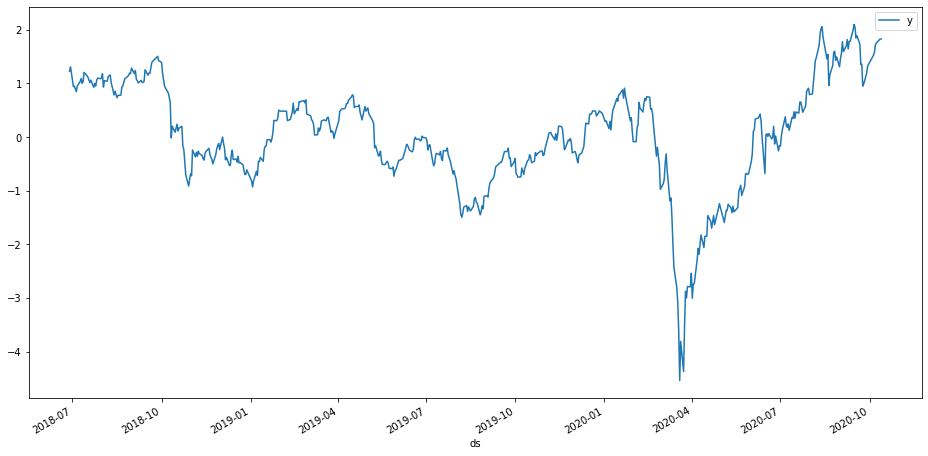

In [26]:
# 데이터의 추이 파악
data.plot(x='ds', y='y', figsize=(16, 8))

In [27]:
# prop_model = Prophet(
#     growth='linear',
#     #changepoints=cp_1,
#     #n_changepoints=25,
#     changepoint_range=0.95,
#     yearly_seasonality='auto',
#     weekly_seasonality='auto',
#     daily_seasonality='auto',
#     holidays=None,
#     seasonality_mode='additive',
#     seasonality_prior_scale=10.0,
#     holidays_prior_scale=10.0,
#     changepoint_prior_scale=0.05,
#     mcmc_samples=0,
#     interval_width=0.8,
#     uncertainty_samples=1000,
#     stan_backend=None,
# )
prop_model=Prophet(yearly_seasonality='auto',
     weekly_seasonality='auto',
     daily_seasonality='auto',
     changepoint_prior_scale=0.15,
     changepoint_range=0.9
     )

model = prop_model
# model = Prophet()
model.add_country_holidays(country_name='KR')
model.fit(data)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
C:\Users\Kim SeoJeong\anaconda3\lib\site-packages\pystan\misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


In [28]:
#!pip install workalendar
from workalendar.asia import SouthKorea
kor_holidays = pd.concat([pd.Series(np.array(SouthKorea().holidays(2020))[:, 0]), pd.Series(np.array(SouthKorea().holidays(2021))[:, 0])]).reset_index(drop=True)

future = model.make_future_dataframe(periods=10)
future = future[future.ds.dt.weekday != 5]
future = future[future.ds.dt.weekday != 6]
for kor_holiday in kor_holidays:
    future = future[future.ds != kor_holiday]
    
future.tail()

,ds
568,2020-10-19
569,2020-10-20
570,2020-10-21
571,2020-10-22
572,2020-10-23


In [29]:
forecast = model.predict(future)
forecast.tail(10)

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,Alternative holiday of Children's Day,Alternative holiday of Children's Day_lower,Alternative holiday of Children's Day_upper,Alternative holiday of Chuseok,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
561,2020-10-12,1.514614,1.238563,2.033288,1.514614,1.514614,0.0,0.0,0.0,0.0,...,-0.088269,-0.088269,-0.088269,0.193442,0.193442,0.193442,0.0,0.0,0.0,1.619787
562,2020-10-13,1.529483,1.214810,2.074656,1.529483,1.529483,0.0,0.0,0.0,0.0,...,-0.041356,-0.041356,-0.041356,0.158603,0.158603,0.158603,0.0,0.0,0.0,1.646730
563,2020-10-14,1.544352,1.226220,2.055051,1.544352,1.544352,0.0,0.0,0.0,0.0,...,-0.031906,-0.031906,-0.031906,0.124821,0.124821,0.124821,0.0,0.0,0.0,1.637267
564,2020-10-15,1.559222,1.198658,2.013714,1.559222,1.559222,0.0,0.0,0.0,0.0,...,-0.053703,-0.053703,-0.053703,0.092438,0.092438,0.092438,0.0,0.0,0.0,1.597957
565,2020-10-16,1.574091,1.186725,1.968017,1.574091,1.574091,0.0,0.0,0.0,0.0,...,-0.049414,-0.049414,-0.049414,0.061778,0.061778,0.061778,0.0,0.0,0.0,1.586455
566,2020-10-19,1.618699,1.091736,1.913317,1.618699,1.618699,0.0,0.0,0.0,0.0,...,-0.088269,-0.088269,-0.088269,-0.017043,-0.017043,-0.017043,0.0,0.0,0.0,1.513387
567,2020-10-20,1.633569,1.129047,1.982795,1.633569,1.633673,0.0,0.0,0.0,0.0,...,-0.041356,-0.041356,-0.041356,-0.038179,-0.038179,-0.038179,0.0,0.0,0.0,1.554034
568,2020-10-21,1.648438,1.148727,1.987562,1.648438,1.651264,0.0,0.0,0.0,0.0,...,-0.031906,-0.031906,-0.031906,-0.056484,-0.056484,-0.056484,0.0,0.0,0.0,1.560048
569,2020-10-22,1.663307,1.125507,1.928037,1.662273,1.671921,0.0,0.0,0.0,0.0,...,-0.053703,-0.053703,-0.053703,-0.071877,-0.071877,-0.071877,0.0,0.0,0.0,1.537728
570,2020-10-23,1.678177,1.121097,1.985090,1.675530,1.690153,0.0,0.0,0.0,0.0,...,-0.049414,-0.049414,-0.049414,-0.084332,-0.084332,-0.084332,0.0,0.0,0.0,1.544431


In [30]:
forecast[['ds','yhat','yhat_upper','yhat_lower']]

,ds,yhat,yhat_upper,yhat_lower
0,2018-06-28,1.107203,1.545522,0.721356
1,2018-06-29,1.096191,1.477035,0.701094
2,2018-07-02,1.016533,1.433910,0.605264
3,2018-07-03,1.052485,1.473378,0.621720
4,2018-07-04,1.052674,1.473445,0.636641
...,...,...,...,...
566,2020-10-19,1.513387,1.913317,1.091736
567,2020-10-20,1.554034,1.982795,1.129047
568,2020-10-21,1.560048,1.987562,1.148727
569,2020-10-22,1.537728,1.928037,1.125507


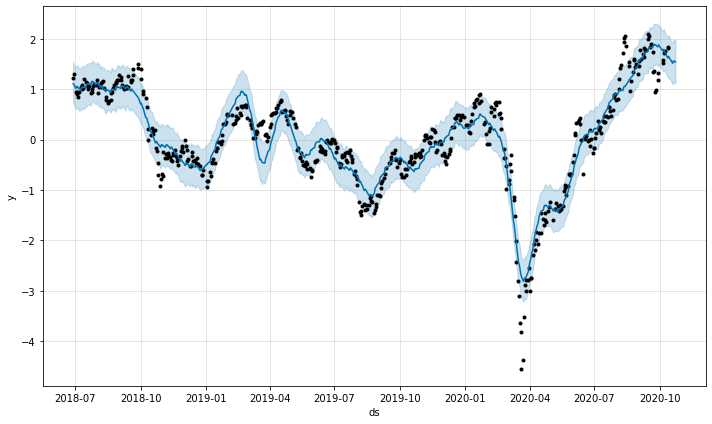

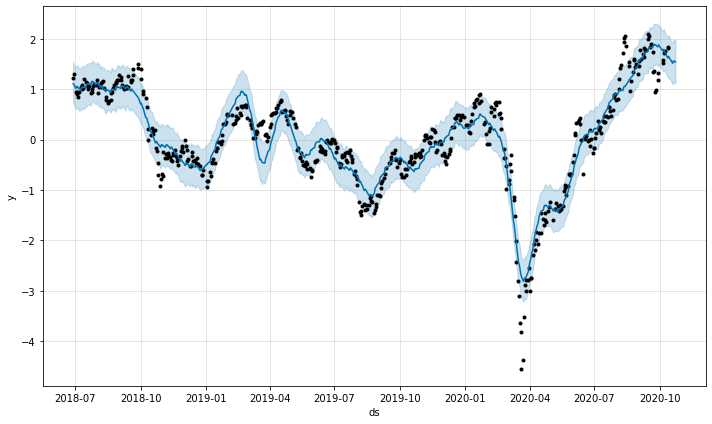

In [31]:
model.plot(forecast)

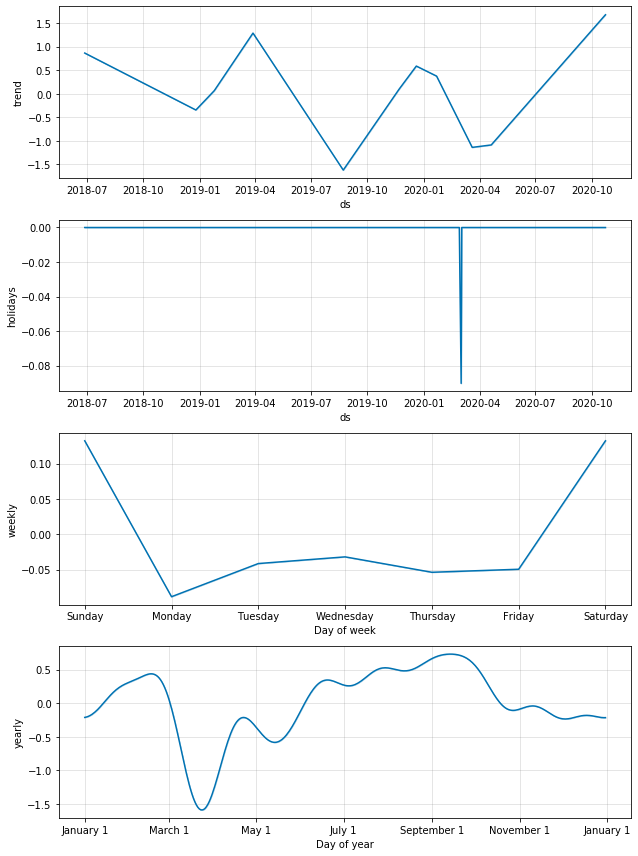

In [32]:
fig2 = model.plot_components(forecast)

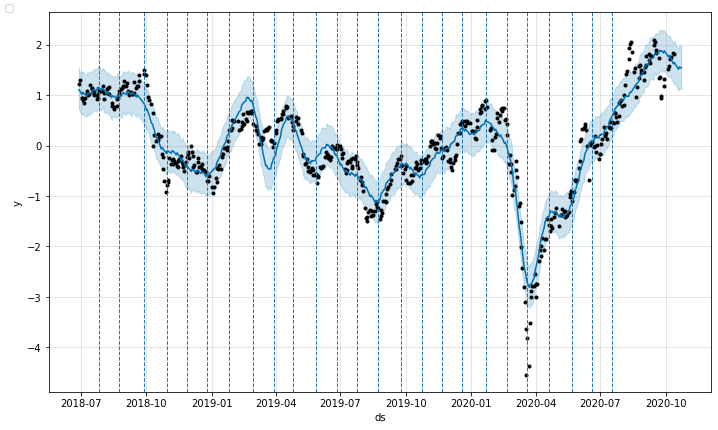

In [33]:
figure = model.plot(forecast)
for changepoint in model.changepoints:
    plt.axvline(changepoint,ls='--', lw=1)
figure.legend(loc=2)


In [34]:
from fbprophet.diagnostics import cross_validation
df.shape

(563, 55)

# Cross Validation

- For measuring forecast error by comparing the predicted values with the actual values
- initial:the size of the initial training period
- period : the spacing between cutoff dates
- horizon : the forecast horizon((ds minus cutoff)
- By default, the initial training period is set to three times the horizon, and cutoffs are made every half a horizon

In [35]:
cv = cross_validation(model,initial='534 days', period='20 days', horizon = '134 days')
cv.head()

INFO:fbprophet:Making 9 forecasts with cutoffs between 2019-12-24 00:00:00 and 2020-06-01 00:00:00


C:\Users\Kim SeoJeong\anaconda3\lib\site-packages\pystan\misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):
C:\Users\Kim SeoJeong\anaconda3\lib\site-packages\pystan\misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):
C:\Users\Kim SeoJeong\anaconda3\lib\site-packages\pystan\misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):
C:\Users\Kim SeoJeong\anaconda3\lib\site-packages\pystan\misc.py:399: FutureWarning: Conversion of the 

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2019-12-26,0.393706,0.127473,0.670847,0.443713,2019-12-24
1,2019-12-27,0.419465,0.158358,0.677345,0.485987,2019-12-24
2,2019-12-30,0.439584,0.153365,0.716590,0.441963,2019-12-24
3,2020-01-02,0.495933,0.235449,0.768639,0.290505,2019-12-24
4,2020-01-03,0.538749,0.263716,0.817556,0.299188,2019-12-24


In [36]:
from fbprophet.diagnostics import performance_metrics
df_pm = performance_metrics(cv)
df_pm

,horizon,mse,rmse,mae,mape,mdape,coverage
0,15 days,1.861390,1.364328,1.181215,2.086227,1.266987,0.097561
1,16 days,2.044073,1.429711,1.242905,2.058918,1.382542,0.097561
2,17 days,2.161294,1.470134,1.287524,2.432334,1.407212,0.085366
3,18 days,2.324256,1.524551,1.337585,2.766087,1.438565,0.097561
4,19 days,2.532394,1.591350,1.390707,2.855762,1.469202,0.097561
...,...,...,...,...,...,...,...
115,130 days,44.771117,6.691122,5.568150,14.110772,6.936809,0.073171
116,131 days,46.229734,6.799245,5.644346,33.326377,6.936809,0.073171
117,132 days,47.248847,6.873780,5.681520,32.944418,7.140153,0.069686
118,133 days,48.318699,6.951165,5.708120,32.635423,7.109613,0.071429


# Visualizing Performance Metrics
- cutoff: how far into the future the prediction was

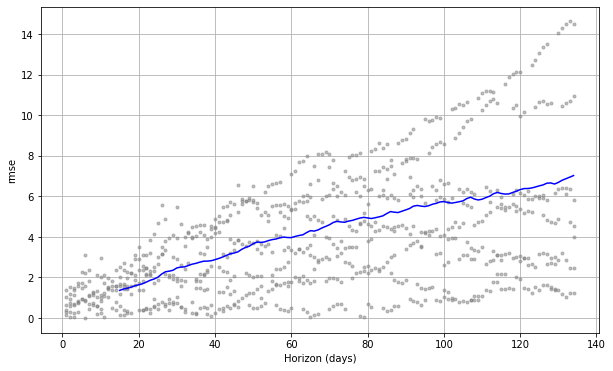

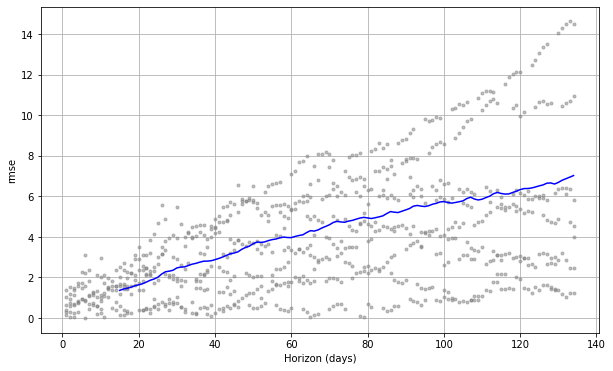

In [37]:
from fbprophet.plot import plot_cross_validation_metric
plot_cross_validation_metric(cv,metric='rmse')

# 2) YG

In [38]:
model_yg.describe()

,Open,High,Low,Close,Volume,Market_Value_x,Value_x,Num_Stock_x,ma_5,ma_10,...,kosdaq_inst_value,kosdaq_indi_value,kosdaq_fore_value,kosdaq_etc_value,kosdaq_short_sell_value,kosdaq_150_Close,kosdaq_150_comm_Close,kosdaq_enter_Close,kosdaq_large_Close,kosdaq_super_Close
count,486.000000,486.000000,486.000000,486.000000,486.000000,486.000000,486.000000,486.000000,486.000000,486.000000,...,486.000000,486.000000,486.000000,486.000000,486.000000,486.000000,486.000000,486.000000,486.000000,486.000000
mean,-0.004033,-0.002870,-0.004014,-0.003207,0.009249,-0.003246,0.007547,-0.002961,-0.001893,-0.000417,...,0.000908,-0.007926,-0.001547,0.004507,-0.001180,-0.002853,-0.004903,-0.002144,-0.003153,-0.001031
std,0.986003,0.987586,0.986598,0.987002,1.011425,0.986947,1.011159,0.996954,0.986994,0.989676,...,1.003293,0.996888,1.001391,1.010946,1.001592,0.989737,0.988442,0.997894,0.990281,0.989950
min,-1.643071,-1.649433,-1.680028,-1.668727,-0.761833,-1.660131,-0.714867,-0.547316,-1.571486,-1.524559,...,-1.512464,-1.123310,-1.386882,-0.310388,-1.466213,-2.795503,-3.091270,-2.905704,-2.802444,-3.246541
25%,-0.836029,-0.849773,-0.845520,-0.840081,-0.439354,-0.837574,-0.471688,-0.547316,-0.853881,-0.872798,...,-0.973298,-1.123310,-1.386882,-0.310388,-1.331811,-0.801256,-0.702146,-0.660337,-0.786414,-0.596588
50%,-0.161652,-0.164157,-0.148663,-0.133785,-0.234268,-0.135852,-0.257377,-0.272906,-0.162095,-0.151022,...,0.055734,-0.012103,0.212569,-0.310388,0.217469,0.002437,-0.086364,-0.132000,-0.025830,-0.176547
75%,0.718632,0.750903,0.682977,0.705985,0.128027,0.702447,0.105729,-0.129936,0.713793,0.736398,...,0.664630,0.463211,0.661765,-0.224888,0.648710,0.787328,0.816026,0.865151,0.723834,0.472792
max,2.745910,2.738512,2.742004,2.696961,12.409565,2.720344,12.020745,4.096210,2.660615,2.640452,...,3.355867,7.018776,2.771600,12.218694,2.661271,2.101468,1.899749,2.156671,2.266828,2.610307


In [39]:
df=copy.deepcopy(model_yg)

In [40]:
#df.date = df.date.astype(str)
#df.date = df.date.str[:4] + '-' + df.date.str[4:6] + '-' + df.date.str[6:]
df['date'] = pd.to_datetime(df.index)

data = df[['date', 'Close']].reset_index(drop=True)

data = data.rename(columns={'date': 'ds', 'Close': 'y'})

data.head()

,ds,y
0,2018-10-05,0.972931
1,2018-10-08,0.750476
2,2018-10-10,0.856142
3,2018-10-11,0.578073
4,2018-10-12,0.705985


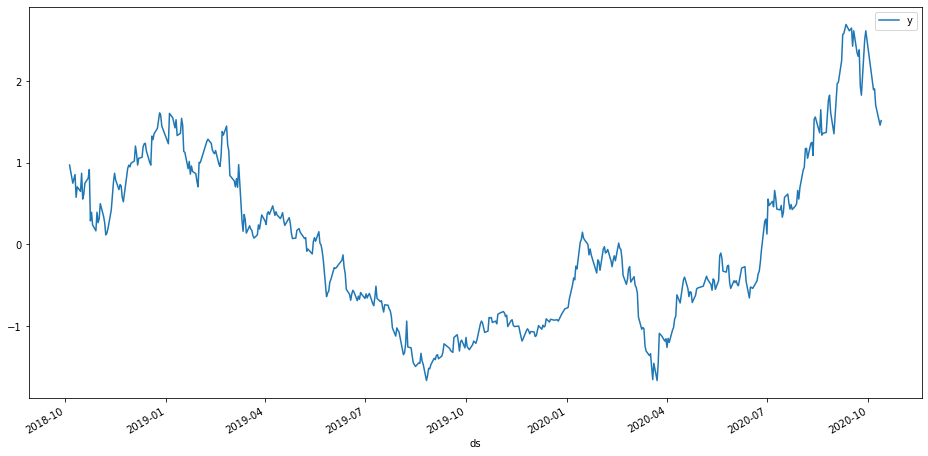

In [41]:
# 데이터의 추이 파악
data.plot(x='ds', y='y', figsize=(16, 8))

In [42]:
# cp=['2019-10-23', '2019-11-04', '2019-11-13', '2019-11-22', '2019-12-04', '2019-12-13', '2019-12-26', '2020-01-08', '2020-01-17', '2020-01-31', '2020-02-11', '2020-02-20', '2020-03-03', '2020-03-12', '2020-03-23', '2020-04-02', '2020-04-13', '2020-04-23', '2020-05-08', '2020-05-19', '2020-05-29', '2020-06-09', '2020-06-18', '2020-06-30', '2020-07-09']

cp_spc=[
 '2020-06-01',
 '2020-06-20',
 '2020-06-23',
 '2020-06-27',
 '2020-07-31',
 '2020-08-11',
 '2020-08-11',
 '2020-08-13',
 '2020-08-18',
 '2020-08-19',
 '2020-08-20',
 '2020-08-26',
 '2020-08-28',
 '2020-08-31',
 '2020-09-02',
 '2020-09-03',
 '2020-09-07',
 '2020-09-08']

cp_default=['2018-10-29',
    '2018-11-19',
    '2018-12-11',
    '2019-01-04',
    '2019-01-29',
    '2019-02-22',
   '2019-03-19',
   '2019-04-10',
   '2019-05-03',
   '2019-05-27',
   '2019-06-19',
   '2019-07-10',
   '2019-08-01',
   '2019-08-26',
   '2019-09-20',
   '2019-10-15',
   '2019-11-07',
   '2019-11-29',
   '2019-12-26',
   '2020-01-20',
   '2020-02-13',
   '2020-03-05',
   '2020-03-30',
   '2020-04-21',
   '2020-05-18']
cp=cp_default+cp_spc
cp

['2018-10-29',
 '2018-11-19',
 '2018-12-11',
 '2019-01-04',
 '2019-01-29',
 '2019-02-22',
 '2019-03-19',
 '2019-04-10',
 '2019-05-03',
 '2019-05-27',
 '2019-06-19',
 '2019-07-10',
 '2019-08-01',
 '2019-08-26',
 '2019-09-20',
 '2019-10-15',
 '2019-11-07',
 '2019-11-29',
 '2019-12-26',
 '2020-01-20',
 '2020-02-13',
 '2020-03-05',
 '2020-03-30',
 '2020-04-21',
 '2020-05-18',
 '2020-06-01',
 '2020-06-20',
 '2020-06-23',
 '2020-06-27',
 '2020-07-31',
 '2020-08-11',
 '2020-08-11',
 '2020-08-13',
 '2020-08-18',
 '2020-08-19',
 '2020-08-20',
 '2020-08-26',
 '2020-08-28',
 '2020-08-31',
 '2020-09-02',
 '2020-09-03',
 '2020-09-07',
 '2020-09-08']

In [43]:
from fbprophet import Prophet
from workalendar.asia import SouthKorea


#     growth='linear',
#     #changepoints=cp_1,
#     #n_changepoints=25,
#     changepoint_range=0.95,
#     yearly_seasonality='auto',
#     weekly_seasonality='auto',
#     daily_seasonality='auto',
#     holidays=None,
#     seasonality_mode='additive',
#     seasonality_prior_scale=10.0,
#     holidays_prior_scale=10.0,
#     changepoint_prior_scale=0.05,
#     mcmc_samples=0,
#     interval_width=0.8,
#     uncertainty_samples=1000,
#     stan_backend=None,

m = Prophet(yearly_seasonality='auto',
     weekly_seasonality='auto',
     daily_seasonality='auto',
     changepoints=cp,
     changepoint_range=0.85,
     changepoint_prior_scale=0.1
     )
m.fit(data)
kor_holidays = pd.concat([pd.Series(np.array(SouthKorea().holidays(2019))[:, 0]), pd.Series(np.array(SouthKorea().holidays(2020))[:, 0])]).reset_index(drop=True)
future = m.make_future_dataframe(periods=pred_days)

future = future[future.ds.dt.weekday != 5]
future = future[future.ds.dt.weekday != 6]
for kor_holiday in kor_holidays:
    future = future[future.ds != kor_holiday]
    
future.tail()
forecast = m.predict(future)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
C:\Users\Kim SeoJeong\anaconda3\lib\site-packages\pystan\misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


In [44]:
forecast[ [ 'ds', 'yhat', 'yhat_lower', 'yhat_upper' ] ].tail(pred_days)

,ds,yhat,yhat_lower,yhat_upper
480,2020-10-05,2.267252,1.962276,2.544663
481,2020-10-06,2.299890,2.009968,2.604246
482,2020-10-07,2.355288,2.066861,2.649968
483,2020-10-08,2.350695,2.075435,2.660746
484,2020-10-12,2.448304,2.166091,2.749159
485,2020-10-13,2.503036,2.210119,2.774162
486,2020-10-14,2.578954,2.286833,2.880069
487,2020-10-15,2.592864,2.313778,2.904231
488,2020-10-16,2.635783,2.355598,2.940897
489,2020-10-19,2.737648,2.441510,3.026732


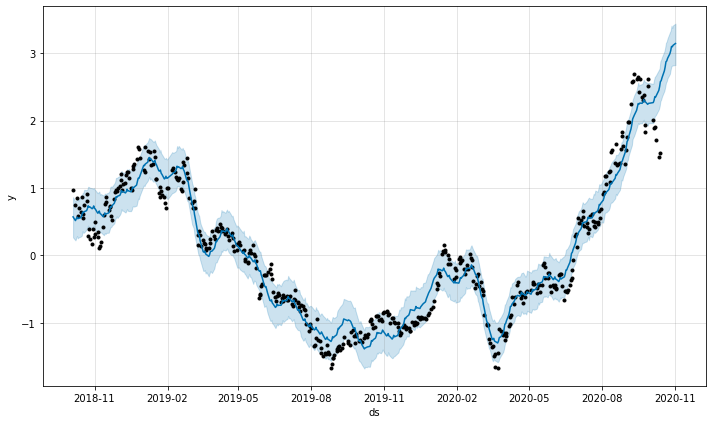

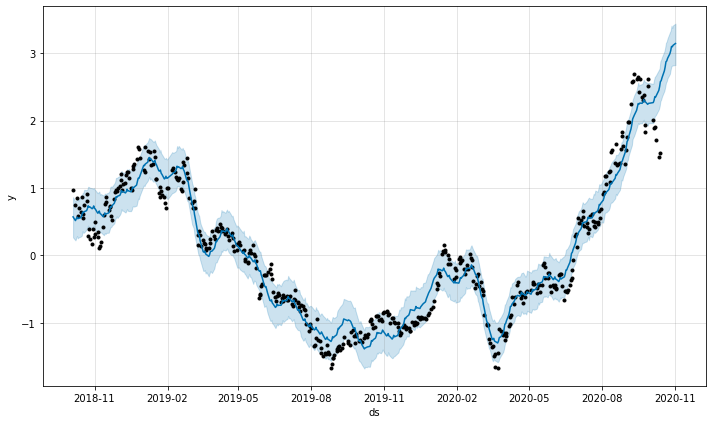

In [45]:
m.plot(forecast)

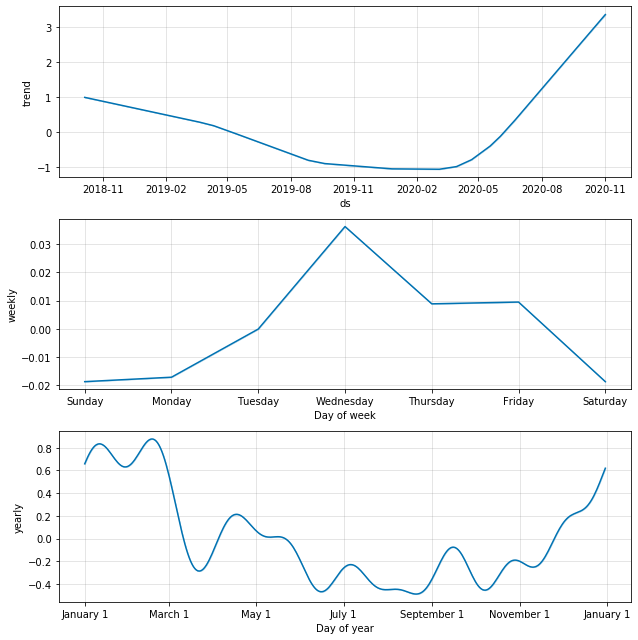

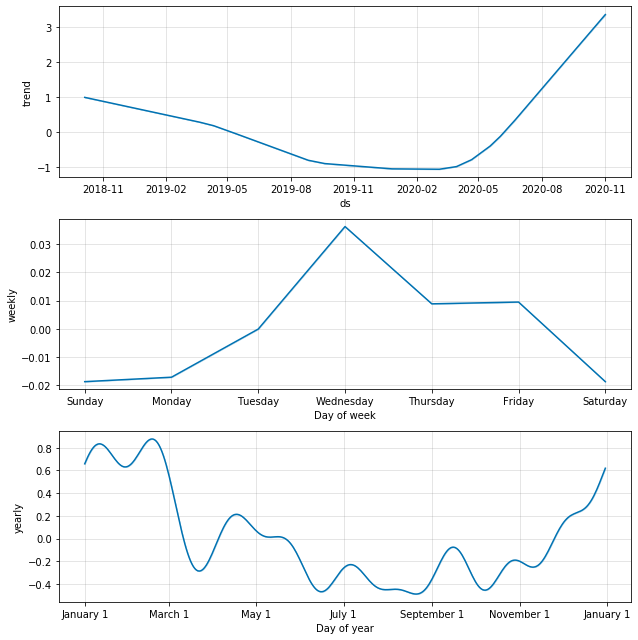

In [46]:
m.plot_components( forecast)

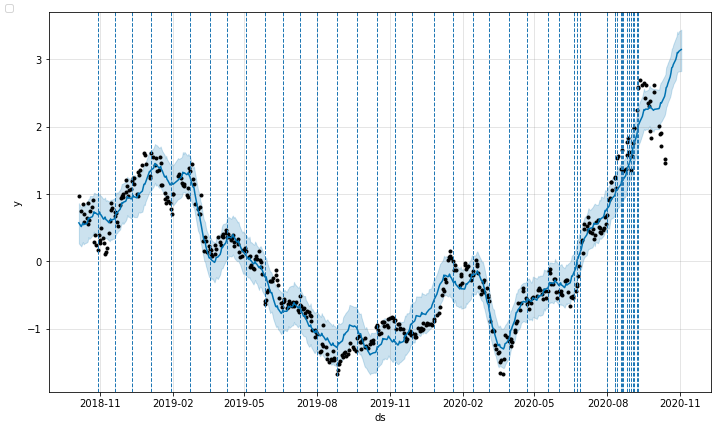

In [47]:
figure = m.plot(forecast)
for changepoint in m.changepoints:
    plt.axvline(changepoint,ls='--', lw=1)
figure.legend(loc=2)

In [48]:
print(m.changepoints)

0    2018-10-29
1    2018-11-19
2    2018-12-11
3    2019-01-04
4    2019-01-29
5    2019-02-22
6    2019-03-19
7    2019-04-10
8    2019-05-03
9    2019-05-27
10   2019-06-19
11   2019-07-10
12   2019-08-01
13   2019-08-26
14   2019-09-20
15   2019-10-15
16   2019-11-07
17   2019-11-29
18   2019-12-26
19   2020-01-20
20   2020-02-13
21   2020-03-05
22   2020-03-30
23   2020-04-21
24   2020-05-18
25   2020-06-01
26   2020-06-20
27   2020-06-23
28   2020-06-27
29   2020-07-31
30   2020-08-11
31   2020-08-11
32   2020-08-13
33   2020-08-18
34   2020-08-19
35   2020-08-20
36   2020-08-26
37   2020-08-28
38   2020-08-31
39   2020-09-02
40   2020-09-03
41   2020-09-07
42   2020-09-08
Name: ds, dtype: datetime64[ns]


In [49]:
# import pickle
# path=
# with open('model.pckl', 'wb') as fout:
#     pickle.dump(m, fout)  

In [50]:
# 예측한 값만 표로 보기
pred=forecast.tail(pred_days)
pred

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
480,2020-10-05,2.728599,1.962276,2.544663,2.728599,2.728599,-0.461347,-0.461347,-0.461347,-0.017091,-0.017091,-0.017091,-0.444255,-0.444255,-0.444255,0.0,0.0,0.0,2.267252
481,2020-10-06,2.751471,2.009968,2.604246,2.751471,2.751471,-0.451581,-0.451581,-0.451581,-0.000066,-0.000066,-0.000066,-0.451515,-0.451515,-0.451515,0.0,0.0,0.0,2.299890
482,2020-10-07,2.774344,2.066861,2.649968,2.774344,2.774344,-0.419055,-0.419055,-0.419055,0.036162,0.036162,0.036162,-0.455217,-0.455217,-0.455217,0.0,0.0,0.0,2.355288
483,2020-10-08,2.797216,2.075435,2.660746,2.797216,2.797216,-0.446521,-0.446521,-0.446521,0.008845,0.008845,0.008845,-0.455367,-0.455367,-0.455367,0.0,0.0,0.0,2.350695
484,2020-10-12,2.888705,2.166091,2.749159,2.888705,2.888705,-0.440402,-0.440402,-0.440402,-0.017091,-0.017091,-0.017091,-0.423310,-0.423310,-0.423310,0.0,0.0,0.0,2.448304
485,2020-10-13,2.911578,2.210119,2.774162,2.911578,2.911578,-0.408542,-0.408542,-0.408542,-0.000066,-0.000066,-0.000066,-0.408476,-0.408476,-0.408476,0.0,0.0,0.0,2.503036
486,2020-10-14,2.934450,2.286833,2.880069,2.934450,2.934450,-0.355496,-0.355496,-0.355496,0.036162,0.036162,0.036162,-0.391658,-0.391658,-0.391658,0.0,0.0,0.0,2.578954
487,2020-10-15,2.957323,2.313778,2.904231,2.957323,2.957323,-0.364458,-0.364458,-0.364458,0.008845,0.008845,0.008845,-0.373304,-0.373304,-0.373304,0.0,0.0,0.0,2.592864
488,2020-10-16,2.980195,2.355598,2.940897,2.980195,2.980195,-0.344412,-0.344412,-0.344412,0.009473,0.009473,0.009473,-0.353885,-0.353885,-0.353885,0.0,0.0,0.0,2.635783
489,2020-10-19,3.048812,2.441510,3.026732,3.048056,3.049304,-0.311164,-0.311164,-0.311164,-0.017091,-0.017091,-0.017091,-0.294073,-0.294073,-0.294073,0.0,0.0,0.0,2.737648


# Cross Validation

- For measuring forecast error by comparing the predicted values with the actual values
- initial:the size of the initial training period
- period : the spacing between cutoff dates
- horizon : the forecast horizon((ds minus cutoff)
- By default, the initial training period is set to three times the horizon, and cutoffs are made every half a horizon


In [51]:
from fbprophet.diagnostics import cross_validation
cv = cross_validation(model,initial='534 days', period='20 days', horizon = '134 days')
cv.head()


INFO:fbprophet:Making 9 forecasts with cutoffs between 2019-12-24 00:00:00 and 2020-06-01 00:00:00


C:\Users\Kim SeoJeong\anaconda3\lib\site-packages\pystan\misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):
C:\Users\Kim SeoJeong\anaconda3\lib\site-packages\pystan\misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):
C:\Users\Kim SeoJeong\anaconda3\lib\site-packages\pystan\misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):
C:\Users\Kim SeoJeong\anaconda3\lib\site-packages\pystan\misc.py:399: FutureWarning: Conversion of the 

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2019-12-26,0.393706,0.140168,0.670390,0.443713,2019-12-24
1,2019-12-27,0.419465,0.159534,0.726110,0.485987,2019-12-24
2,2019-12-30,0.439584,0.159131,0.725947,0.441963,2019-12-24
3,2020-01-02,0.495933,0.229206,0.776924,0.290505,2019-12-24
4,2020-01-03,0.538749,0.272642,0.809758,0.299188,2019-12-24


In [52]:
from fbprophet.diagnostics import performance_metrics
df_pm = performance_metrics(cv)
df_pm

,horizon,mse,rmse,mae,mape,mdape,coverage
0,15 days,1.861390,1.364328,1.181215,2.086227,1.266987,0.109756
1,16 days,2.044073,1.429711,1.242905,2.058918,1.382542,0.097561
2,17 days,2.161294,1.470134,1.287524,2.432334,1.407212,0.085366
3,18 days,2.324256,1.524551,1.337585,2.766087,1.438565,0.097561
4,19 days,2.532394,1.591350,1.390707,2.855762,1.469202,0.097561
...,...,...,...,...,...,...,...
115,130 days,44.771117,6.691122,5.568150,14.110772,6.936809,0.048780
116,131 days,46.229734,6.799245,5.644346,33.326377,6.936809,0.048780
117,132 days,47.248847,6.873780,5.681520,32.944418,7.140153,0.048780
118,133 days,48.318699,6.951165,5.708120,32.635423,7.109613,0.060976


# Visualizing Performance Metrics
- cutoff: how far into the future the prediction was

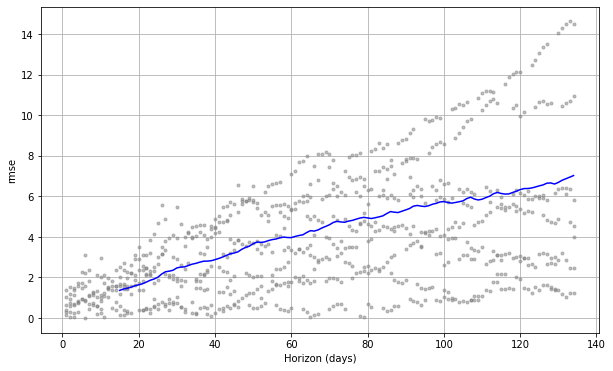

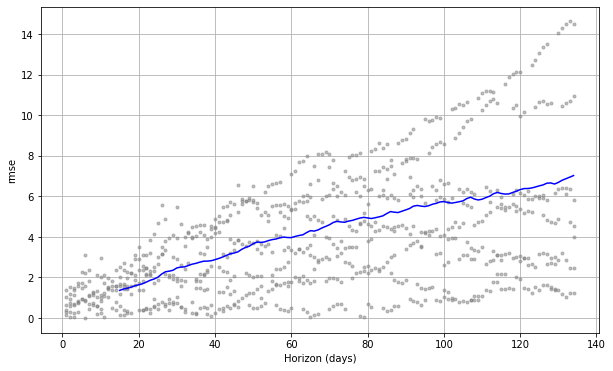

In [53]:
from fbprophet.plot import plot_cross_validation_metric
plot_cross_validation_metric(cv,metric='rmse')

In [54]:
model_yg

,Open,High,Low,Close,Volume,Market_Value_x,Value_x,Num_Stock_x,ma_5,ma_10,...,kosdaq_indi_value,kosdaq_fore_value,kosdaq_etc_value,kosdaq_short_sell_value,kosdaq_150_Close,kosdaq_150_comm_Close,kosdaq_enter_Close,kosdaq_large_Close,kosdaq_super_Close,Labeling
2018-10-05,1.126299,1.055018,1.044311,0.972931,-0.261228,0.958987,-0.128596,-0.547316,1.149632,1.108101,...,0.043613,0.894124,-0.287564,0.853517,1.492230,1.806304,1.549501,1.347739,0.621061,2
2018-10-08,0.943885,0.940975,0.763274,0.750476,-0.040239,0.738308,0.065516,-0.547316,1.082277,1.091025,...,0.536403,0.434098,0.116231,0.502028,1.398087,1.382846,1.361370,1.259362,0.595833,2
2018-10-10,0.761472,0.750903,0.688713,0.856142,0.052909,0.843132,0.141716,-0.547316,0.980123,1.076794,...,0.335589,1.442875,-0.310388,1.308652,1.264945,1.314065,1.167188,1.137864,0.361653,1
2018-10-11,0.766999,0.718320,0.619887,0.578073,0.078775,0.567284,0.152545,-0.547316,0.867866,1.031825,...,1.104395,1.056419,-0.310388,1.348176,0.867895,0.977877,0.791630,0.726742,-0.093665,2
2018-10-12,0.545892,0.669444,0.660036,0.705985,-0.305221,0.694175,-0.219816,-0.547316,0.781428,0.995395,...,3.561302,0.616819,0.016704,0.731942,1.232236,1.217222,1.017753,1.057955,0.143936,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-10-06,1.938868,1.945641,1.904628,1.896121,0.554573,1.937710,1.022024,4.096210,2.193625,2.305749,...,-1.123310,-1.386882,-0.310388,-1.439336,1.585883,1.445259,0.045718,1.779495,2.152495,2
2020-10-07,1.894647,1.891335,2.019337,1.907244,-0.151666,1.948861,0.135742,4.096210,2.209341,2.232888,...,-1.123310,-1.386882,-0.310388,-1.424216,1.643194,1.473937,0.083288,1.843647,2.242646,1
2020-10-08,1.916757,1.837029,1.784184,1.707034,1.143448,1.748059,1.682001,4.096210,2.047690,2.166858,...,-1.123310,-1.386882,-0.310388,-1.405566,1.636904,1.420904,0.049236,1.852705,2.288613,2
2020-10-12,1.739872,1.630665,1.577708,1.462333,1.196640,1.502626,1.644425,4.096210,1.814195,2.080336,...,-1.123310,-1.386882,-0.310388,-1.402681,1.649204,1.376555,0.023204,1.870391,2.306287,2


# Auto_ML

1) 예측 대상 설정 및 학습모델 선정 후 생성

In [55]:
print(model_yg.columns)
print(model_kospi.columns)

Index(['Open', 'High', 'Low', 'Close', 'Volume', 'Market_Value_x', 'Value_x',
       'Num_Stock_x', 'ma_5', 'ma_10', 'ma_15', 'ma_20', 'ma_30', 'ma_60',
       'ma_120', 'ema_5', 'ema_10', 'ema_15', 'ema_20', 'ema_30', 'ema_60',
       'ema_120', 'wma_5', 'wma_10', 'wma_15', 'wma_20', 'wma_30', 'wma_60',
       'wma_120', 'ma_v5', 'ma_v10', 'ma_v20', 'ma_v60', 'ma_v120', 'ubb',
       'mbb', 'lbb', 'macd', 'macdsignal9', 'macdhist', 'rsi', 'slowk',
       'slowd', 'fastk', 'fastd', 'fastk_rsi', 'fastd_rsi', 'cci', 'willR',
       'sar', 'adx', 'plus_di', 'plus_dm', 'atr', 'obv', 'var',
       'Market_Value_y', 'Value_y', 'Num_Stock_y', 'DIV', 'BPS', 'PER', 'EPS',
       'PBR', 'yg_short_sell', 'yg_balance', 'yg_short_sell_value_x',
       'yg_balance_value', 'yg_short_sell_volume', 'yg_total_volume',
       'yg_short_sell_rate', 'yg_short_sell_value_y', 'kosdaq_inst_volume',
       'kosdaq_indi_volume', 'kosdaq_fore_volume', 'kosdaq_etc_volume',
       'kosdaq_short_sell_volume', 'kosd

# Train : Test = 7 : 3으로 하고 싶다면, 70을 입력
# Train : Test = 8 : 2으로 하고 싶다면, 80을 입력

In [56]:
text_model=input("예측할 대상 입력 : (코스피 OR YG) : ")
text_model=text_model.strip()

if text_model=='코스피':
    # 코스피 지수 예측 모델
    train = model_kospi
    while(1):
        text=int(input("분류모델은 1을 입력 / 회귀모델은 2를 입력 : "))
        if text==1:
            clf = setup(data = train, target = 'Labeling', feature_selection = True, ignore_low_variance = True)
            break
        elif text==2:
            train=copy.deepcopy(model_kospi)
            train=train[train.columns.difference(['Labeling'])]
            #del train['Labeling']
            reg = setup(data = train, target = 'Close', feature_selection = True, ignore_low_variance = True)
            break
        else:
            print("다시 입력하세요")

        
        
    
else:
    # 와이지엔터테인먼트 주가 예측 모델
    train = model_yg
    while(1):
        text=int(input("분류모델은 1을 입력 / 회귀모델은 2를 입력 : "))
        if text==1:
            from pycaret.classification import * # AutoML pycaret
            clf = setup(data = train, target = 'Labeling', feature_selection = True, ignore_low_variance = True)
            break
        elif text==2:
            
            train=copy.deepcopy(model_yg)
            train=train[train.columns.difference(['Labeling'])]
            #del train['Labeling']
            print(train)
            reg = setup(data = train, target = 'Close', feature_selection = True, ignore_low_variance = True)
            break
        else:
            print("다시 입력하세요")

 
Setup Succesfully Completed.


,Description,Value
0,session_id,5540
1,Transform Target,False
2,Transform Target Method,None
3,Original Data,"(563, 53)"
4,Missing Values,False
5,Numeric Features,52
6,Categorical Features,0
7,Ordinal Features,False
8,High Cardinality Features,False
9,High Cardinality Method,None


INFO:logs:create_model_container: 0
INFO:logs:master_model_container: 0
INFO:logs:display_container: 0
INFO:logs:setup() succesfully completed......................................


In [57]:
best_3 = compare_models(n_select = 3)

INFO:logs:Initializing compare_models()
INFO:logs:compare_models(exclude=None, include=None, fold=10, round=4, sort=R2, n_select=3, turbo=True, verbose=True)
INFO:logs:Checking exceptions
INFO:logs:Preloading libraries
INFO:logs:Preparing display monitor


IntProgress(value=0, description='Processing: ', max=253)

,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,17:06:34
Status,. . . . . . . . . . . . . . . . . .,Compiling Final Model
Estimator,. . . . . . . . . . . . . . . . . .,Random Sample Consensus
ETC,. . . . . . . . . . . . . . . . . .,Almost Finished


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
0,TheilSen Regressor,1.290000e-02,4.000000e-04,1.970000e-02,9.996000e-01,0.0104,-1.220000e-02,3.9113
1,Linear Regression,1.400000e-02,6.000000e-04,2.290000e-02,9.994000e-01,0.0113,-9.000000e-04,0.0135
2,Random Sample Consensus,1.400000e-02,6.000000e-04,2.290000e-02,9.994000e-01,0.0113,-9.000000e-04,0.0160
3,Bayesian Ridge,1.500000e-02,7.000000e-04,2.450000e-02,9.993000e-01,0.0119,1.290000e-02,0.0256
4,Ridge Regression,2.880000e-02,2.100000e-03,4.360000e-02,9.980000e-01,0.0216,4.200000e-03,0.0108
5,Huber Regressor,2.740000e-02,2.100000e-03,4.250000e-02,9.980000e-01,0.0211,3.820000e-02,0.0709
6,Orthogonal Matching Pursuit,4.280000e-02,3.700000e-03,5.830000e-02,9.963000e-01,0.0320,-1.960000e-02,0.0120
7,Passive Aggressive Regressor,5.590000e-02,5.800000e-03,7.420000e-02,9.941000e-01,0.0402,-2.456000e-01,0.0110
8,CatBoost Regressor,4.330000e-02,6.800000e-03,7.470000e-02,9.935000e-01,0.0328,-1.492000e-01,10.8547
9,Gradient Boosting Regressor,5.050000e-02,7.000000e-03,7.950000e-02,9.931000e-01,0.0362,-3.113000e-01,0.4483


INFO:logs:Copying training dataset
INFO:logs:Importing libraries
INFO:logs:Importing untrained models
INFO:logs:Import successful
INFO:logs:Defining folds
INFO:logs:Declaring metric variables
INFO:logs:Initializing Linear Regression
INFO:logs:Initializing Fold 1
INFO:logs:Total runtime is 0.00016622543334960939 minutes
INFO:logs:Fitting Model
INFO:logs:Evaluating Metrics
INFO:logs:No inverse transformer found
INFO:logs:Compiling Metrics
INFO:logs:Initializing Fold 2
INFO:logs:Total runtime is 0.001512614885965983 minutes
INFO:logs:Fitting Model
INFO:logs:Evaluating Metrics
INFO:logs:No inverse transformer found
INFO:logs:Compiling Metrics
INFO:logs:Initializing Fold 3
INFO:logs:Total runtime is 0.0022273540496826174 minutes
INFO:logs:Fitting Model
INFO:logs:Evaluating Metrics
INFO:logs:No inverse transformer found
INFO:logs:Compiling Metrics
INFO:logs:Initializing Fold 4
INFO:logs:Total runtime is 0.002942164738972982 minutes
INFO:logs:Fitting Model
INFO:logs:Evaluating Metrics
INFO:lo

KeyboardInterrupt: 

In [ ]:
blended = blend_models(estimator_list = best_3, fold = 5)

In [ ]:
pred_holdout = predict_model(blended)

In [ ]:
final_model = finalize_model(blended)

In [ ]:
save_model(final_model, model_name = 'deployment_20201020')

In [ ]:
train

In [ ]:
predictions = predict_model(final_model)

In [ ]:
predictions

In [ ]:
score = predictions[['Close', 'Label']]
#score.to_csv('kospi_score_reg.csv', index = False
score

In [ ]:
plt.figure(figsize=(15,12))
plt.plot(score)


# fig = plt.figure(figsize=(15,12))
# ax1 = fig.add_subplot(211)
# ax1.plot(score['Close'],color='K',label='Y')
# ax1.plot(score['Label'],color='red',label='Yhat')
# ax1.set_xlabel('Date')
# ax1.set_ylabel('값')
# ax1.legend(loc='best')
# plt.show


# LightGBM 

In [ ]:
lgbm  = create_model('lightgbm')

In [ ]:
tuned_lgbm = tune_model(lgbm)

In [ ]:
plot_model(tuned_lgbm, plot = 'learning')

In [ ]:
plot_model(estimator = tuned_lgbm, plot = 'feature')

In [ ]:
evaluate_model(tuned_lgbm)

In [ ]:
predict_model(tuned_lgbm)

In [ ]:
predictions = predict_model(tuned_lgbm)
predictions.head()

In [ ]:
score = predictions[['Close', 'Label']]
#score.to_csv('kospi_score_reg.csv', index = False)
score.head()

In [ ]:
plt.figure(figsize=(15,12))
plt.plot(score)